In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3341, done.
remote: Counting objects: 100% (612/612), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 3341 (delta 531), reused 458 (delta 387), pack-reused 2729 (from 1)
Receiving objects: 100% (3341/3341), 233.19 MiB | 11.33 MiB/s, done.
Resolving deltas: 100% (2581/2581), done.
Updating files: 100% (144/144), done.


In [2]:
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e . -q
!pip install xraydb -q
!pip install xopt -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.6/724.6 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.

In [4]:
!pip install scipy==1.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 32.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xopt 2.5.5 requires scipy>=1.10.1, but you have scipy 1.10.0 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.0 which is incompatible.
imbalanced-learn 0.13.0 requires scipy<2,>=1.10.1, but you have scipy 1.10.0 which is incompatible.
cvxpy 1.6.2 requires scipy>=1.11.0, but you have scipy 1.10.0 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.0 which i

In [70]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import trange
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from scipy.stats import qmc
from split_and_delay import SND

import torch
import gpytorch
import botorch
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator, ExpectedImprovementGenerator, TDUpperConfidenceBoundGenerator, TDExpectedImprovementGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

In [77]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*5e-6 - 2.5e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])



    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    result.append((do_centroid)*1e6)#my_intensity)/(61441.4336))
    del snd
  return torch.tensor(result, dtype=torch.float)

In [108]:
input = np.ones((1,8)) * 0.75
get_snd_outputs(input)

tensor([10.1311])

In [66]:
def f(input_dict: dict) -> dict:
  current_time = time.time()
  temp = current_time - start_time
  if temp > 50:
    t = current_time - start_time
  else:
    t = 0.0
  drift_mag = 0.0001
  print(f"Shift: {t*drift_mag}")
  drift_dir = np.array([1, -1, -1, 1, 1, 1, -1, -1])
  noise = np.random.rand(8) * drift_mag * 0.01
  drift_vec = drift_mag * drift_dir + noise
  drift = t * drift_vec

  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"] + drift[0], input_dict["x2"] + drift[1], input_dict["x3"] + drift[2], input_dict["x4"] + drift[3], input_dict["x5"] + drift[4], input_dict["x6"] + drift[5], input_dict["x7"] + drift[6], input_dict["x8"] + drift[7]

  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f, "time": float(current_time)}

In [ ]:
def eval_function(input_dict: dict) -> dict:
  drift = 0.01
  if time > 20:
    x1, x2, x3, x4 = input_dict["x1"] + time*drift, input_dict["x2"] + time*drift, input_dict["x3"] + time*drift, input_dict["x4"] + time*drift
  else:
    x1, x2, x3, x4 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f}

In [98]:
low =  0.0
high = 1.0
n_init = 128

vocs = VOCS(
    variables = {"x1": [low, high],
                "x2": [low, high],
                "x3": [low, high],
                "x4": [low, high],
                 "x5": [low, high],
                "x6": [low, high],
                "x7": [low, high],
                "x8": [low, high],
                 },
    objectives = {"f": "MINIMIZE"},
  )

evaluator = Evaluator(function=f)

generator = TDUpperConfidenceBoundGenerator(
    vocs=vocs,
    beta=0.00001,
    added_time=0.1,
    forgetting_time=200.0, #change this from 100
)
generator.n_monte_carlo_samples = 128
generator.numerical_optimizer.n_restarts = 20
generator.max_travel_distances = [4.0] * 8

start_time = time.time()
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
#X.random_evaluate(128)
sampler = qmc.LatinHypercube(d=8)
xs = sampler.random(n=n_init)
xs -= 0.5
xs /= 10
xs += 0.5

init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
X.evaluate_data(init_samples)

for i in trange(800):
  print(f"Step: {i+1} \t Time: {time.time() - start_time}")
  X.step()
  currentstate = X.generator.data["f"][-1:]
  print(f"Current State: {currentstate}")
  time.sleep(0.1)

Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0

  0%|          | 0/800 [00:00<?, ?it/s]

Step: 1 	 Time: 47.31559658050537
Shift: 0.005294818115234376
Current State: 128    0.472661
Name: f, dtype: float64


  0%|          | 1/800 [00:06<1:21:59,  6.16s/it]

Step: 2 	 Time: 53.47393441200256
Shift: 0.005840709376335144
Current State: 129    1.260386
Name: f, dtype: float64


  0%|          | 2/800 [00:11<1:15:29,  5.68s/it]

Step: 3 	 Time: 58.812888383865356
Shift: 0.006356360602378846
Current State: 130    0.570502
Name: f, dtype: float64


  0%|          | 3/800 [00:16<1:12:39,  5.47s/it]

Step: 4 	 Time: 64.03679990768433
Shift: 0.00720632073879242
Current State: 131    0.372382
Name: f, dtype: float64


  0%|          | 4/800 [00:25<1:28:04,  6.64s/it]

Step: 5 	 Time: 72.46932482719421
Shift: 0.00778292088508606
Current State: 132    0.659266
Name: f, dtype: float64


  1%|          | 5/800 [00:31<1:24:29,  6.38s/it]

Step: 6 	 Time: 78.38071870803833
Shift: 0.00849628050327301
Current State: 133    0.631147
Name: f, dtype: float64


  1%|          | 6/800 [00:38<1:27:10,  6.59s/it]

Step: 7 	 Time: 85.37802219390869
Shift: 0.00901113133430481
Current State: 134    0.572831
Name: f, dtype: float64


  1%|          | 7/800 [00:43<1:21:22,  6.16s/it]

Step: 8 	 Time: 90.64836645126343
Shift: 0.0096257465839386
Current State: 135    0.896507
Name: f, dtype: float64


  1%|          | 8/800 [00:49<1:20:38,  6.11s/it]

Step: 9 	 Time: 96.65516066551208
Shift: 0.010205358028411866
Current State: 136    0.230236
Name: f, dtype: float64


  1%|          | 9/800 [00:55<1:19:43,  6.05s/it]

Step: 10 	 Time: 102.56485533714294
Shift: 0.010751401376724245
Current State: 137    0.230562
Name: f, dtype: float64


  1%|▏         | 10/800 [01:00<1:16:48,  5.83s/it]

Step: 11 	 Time: 107.91989469528198
Shift: 0.011455987668037414
Current State: 138    0.402574
Name: f, dtype: float64


  1%|▏         | 11/800 [01:07<1:22:14,  6.25s/it]

Step: 12 	 Time: 115.12850856781006
Shift: 0.011868384790420532
Current State: 139    0.290341
Name: f, dtype: float64


  2%|▏         | 12/800 [01:11<1:12:57,  5.56s/it]

Step: 13 	 Time: 119.08477330207825
Shift: 0.012415593481063844
Current State: 140    0.304762
Name: f, dtype: float64


  2%|▏         | 13/800 [01:17<1:12:29,  5.53s/it]

Step: 14 	 Time: 124.54754996299744
Shift: 0.012972863626480103
Current State: 141    0.340561
Name: f, dtype: float64


  2%|▏         | 14/800 [01:22<1:12:45,  5.55s/it]

Step: 15 	 Time: 130.16322422027588
Shift: 0.01354004638195038
Current State: 142    0.369157
Name: f, dtype: float64


  2%|▏         | 15/800 [01:28<1:12:59,  5.58s/it]

Step: 16 	 Time: 135.80063438415527
Shift: 0.014090028619766236
Current State: 143    0.393463
Name: f, dtype: float64


  2%|▏         | 16/800 [01:34<1:12:57,  5.58s/it]

Step: 17 	 Time: 141.3943953514099
Shift: 0.01472594714164734
Current State: 144    0.422826
Name: f, dtype: float64


  2%|▏         | 17/800 [01:40<1:15:37,  5.80s/it]

Step: 18 	 Time: 147.68193888664246
Shift: 0.015267201972007751
Current State: 145    0.447267
Name: f, dtype: float64


  2%|▏         | 18/800 [01:45<1:14:44,  5.73s/it]

Step: 19 	 Time: 153.27667927742004
Shift: 0.01587612113952637
Current State: 146    0.47256
Name: f, dtype: float64


  2%|▏         | 19/800 [01:51<1:15:22,  5.79s/it]

Step: 20 	 Time: 159.19559502601624
Shift: 0.016492448163032532
Current State: 147    0.489897
Name: f, dtype: float64


  2%|▎         | 20/800 [01:58<1:19:33,  6.12s/it]

Step: 21 	 Time: 166.08243608474731
Shift: 0.01695131907463074
Current State: 148    0.53407
Name: f, dtype: float64


  3%|▎         | 21/800 [02:02<1:10:37,  5.44s/it]

Step: 22 	 Time: 169.93483424186707
Shift: 0.017413787627220154
Current State: 149    0.486112
Name: f, dtype: float64


  3%|▎         | 22/800 [02:07<1:07:20,  5.19s/it]

Step: 23 	 Time: 174.55358982086182
Shift: 0.0180655277967453
Current State: 150    0.345067
Name: f, dtype: float64


  3%|▎         | 23/800 [02:13<1:12:22,  5.59s/it]

Step: 24 	 Time: 181.06798124313354
Shift: 0.01847897593975067
Current State: 151    0.173406
Name: f, dtype: float64


  3%|▎         | 24/800 [02:17<1:06:39,  5.15s/it]

Step: 25 	 Time: 185.20875191688538
Shift: 0.018906530761718752
Current State: 152    0.179123
Name: f, dtype: float64


  3%|▎         | 25/800 [02:22<1:03:12,  4.89s/it]

Step: 26 	 Time: 189.49079656600952
Shift: 0.019588706183433533
Current State: 153    0.189032
Name: f, dtype: float64


  3%|▎         | 26/800 [02:28<1:10:31,  5.47s/it]

Step: 27 	 Time: 196.2977933883667
Shift: 0.020168891286849976
Current State: 154    0.1567
Name: f, dtype: float64


  3%|▎         | 27/800 [02:34<1:11:46,  5.57s/it]

Step: 28 	 Time: 202.11160492897034
Shift: 0.02082364947795868
Current State: 155    0.13901
Name: f, dtype: float64


  4%|▎         | 28/800 [02:41<1:15:27,  5.86s/it]

Step: 29 	 Time: 208.66067910194397
Shift: 0.02129523050785065
Current State: 156    0.145791
Name: f, dtype: float64


  4%|▎         | 29/800 [02:46<1:10:54,  5.52s/it]

Step: 30 	 Time: 213.3713607788086
Shift: 0.021805604100227357
Current State: 157    0.077685
Name: f, dtype: float64


  4%|▍         | 30/800 [02:51<1:09:12,  5.39s/it]

Step: 31 	 Time: 218.4729835987091
Shift: 0.022091585540771487
Current State: 158    0.207658
Name: f, dtype: float64


  4%|▍         | 31/800 [02:53<59:19,  4.63s/it]  

Step: 32 	 Time: 221.31604051589966
Shift: 0.022287517952919007
Current State: 159    1.560217
Name: f, dtype: float64


  4%|▍         | 32/800 [02:55<48:59,  3.83s/it]

Step: 33 	 Time: 223.2768635749817
Shift: 0.022707302355766297
Current State: 160    0.054153
Name: f, dtype: float64


  4%|▍         | 33/800 [03:00<50:23,  3.94s/it]

Step: 34 	 Time: 227.48512887954712
Shift: 0.023127775382995607
Current State: 161    0.159012
Name: f, dtype: float64


  4%|▍         | 34/800 [03:04<51:19,  4.02s/it]

Step: 35 	 Time: 231.68928790092468
Shift: 0.0232789092540741
Current State: 162    0.505233
Name: f, dtype: float64


  4%|▍         | 35/800 [03:05<41:38,  3.27s/it]

Step: 36 	 Time: 233.19474577903748
Shift: 0.023396872830390932
Current State: 163    0.965343
Name: f, dtype: float64


  4%|▍         | 36/800 [03:07<33:37,  2.64s/it]

Step: 37 	 Time: 234.3743395805359
Shift: 0.023479276490211486
Current State: 164    1.097659
Name: f, dtype: float64


  5%|▍         | 37/800 [03:07<26:40,  2.10s/it]

Step: 38 	 Time: 235.2050802707672
Shift: 0.023570038056373598
Current State: 165    7.287779
Name: f, dtype: float64


  5%|▍         | 38/800 [03:08<22:10,  1.75s/it]

Step: 39 	 Time: 236.13175106048584
Shift: 0.023799417257308962
Current State: 166    0.775181
Name: f, dtype: float64


  5%|▍         | 39/800 [03:11<24:08,  1.90s/it]

Step: 40 	 Time: 238.40476322174072
Shift: 0.02389242949485779
Current State: 167    1.564231
Name: f, dtype: float64


  5%|▌         | 40/800 [03:12<20:26,  1.61s/it]

Step: 41 	 Time: 239.3394055366516
Shift: 0.024048356294631958
Current State: 168    0.271203
Name: f, dtype: float64


  5%|▌         | 41/800 [03:13<20:54,  1.65s/it]

Step: 42 	 Time: 241.08340311050415
Shift: 0.02426094992160797
Current State: 169    0.172033
Name: f, dtype: float64


  5%|▌         | 42/800 [03:15<21:56,  1.74s/it]

Step: 43 	 Time: 243.01821160316467
Shift: 0.024466208362579348
Current State: 170    0.541189
Name: f, dtype: float64


  5%|▌         | 43/800 [03:17<23:06,  1.83s/it]

Step: 44 	 Time: 245.06779599189758
Shift: 0.024601950049400332
Current State: 171    0.166098
Name: f, dtype: float64


  6%|▌         | 44/800 [03:19<21:22,  1.70s/it]

Step: 45 	 Time: 246.45096707344055
Shift: 0.024760000324249267
Current State: 172    0.115989
Name: f, dtype: float64


  6%|▌         | 45/800 [03:20<20:50,  1.66s/it]

Step: 46 	 Time: 248.01419043540955
Shift: 0.024860490393638614
Current State: 173    1.658632
Name: f, dtype: float64


  6%|▌         | 46/800 [03:21<18:20,  1.46s/it]

Step: 47 	 Time: 249.01321578025818
Shift: 0.02501760280132294
Current State: 174    1.0517
Name: f, dtype: float64


  6%|▌         | 47/800 [03:23<18:46,  1.50s/it]

Step: 48 	 Time: 250.59289455413818
Shift: 0.025156999325752258
Current State: 175    1.022716
Name: f, dtype: float64


  6%|▌         | 48/800 [03:24<18:24,  1.47s/it]

Step: 49 	 Time: 251.99891591072083
Shift: 0.025257094645500185
Current State: 176    1.634975
Name: f, dtype: float64


  6%|▌         | 49/800 [03:25<17:16,  1.38s/it]

Step: 50 	 Time: 253.17290949821472
Shift: 0.025434730672836307
Current State: 177    0.796207
Name: f, dtype: float64


  6%|▋         | 50/800 [03:27<18:33,  1.48s/it]

Step: 51 	 Time: 254.90203261375427
Shift: 0.025731775045394898
Current State: 178    0.146081
Name: f, dtype: float64


  6%|▋         | 51/800 [03:30<23:39,  1.89s/it]

Step: 52 	 Time: 257.75236201286316
Shift: 0.02589901523590088
Current State: 179    0.728034
Name: f, dtype: float64


  6%|▋         | 52/800 [03:32<22:42,  1.82s/it]

Step: 53 	 Time: 259.40323662757874
Shift: 0.026055563497543337
Current State: 180    1.558461
Name: f, dtype: float64


  7%|▋         | 53/800 [03:33<21:47,  1.75s/it]

Step: 54 	 Time: 260.98610377311707
Shift: 0.02616867117881775
Current State: 181    0.677705
Name: f, dtype: float64


  7%|▋         | 54/800 [03:34<19:26,  1.56s/it]

Step: 55 	 Time: 262.1137897968292
Shift: 0.026323938703536987
Current State: 182    0.177951
Name: f, dtype: float64


  7%|▋         | 55/800 [03:36<19:20,  1.56s/it]

Step: 56 	 Time: 263.6602506637573
Shift: 0.02671730818748474
Current State: 183    0.193356
Name: f, dtype: float64


  7%|▋         | 56/800 [03:40<28:45,  2.32s/it]

Step: 57 	 Time: 267.7567777633667
Shift: 0.026847448420524597
Current State: 184    0.702062
Name: f, dtype: float64


  7%|▋         | 57/800 [03:41<24:19,  1.96s/it]

Step: 58 	 Time: 268.89260959625244
Shift: 0.027019856500625612
Current State: 185    0.212452
Name: f, dtype: float64


  7%|▋         | 58/800 [03:43<23:22,  1.89s/it]

Step: 59 	 Time: 270.6112914085388
Shift: 0.02715199966430664
Current State: 186    0.217918
Name: f, dtype: float64


  7%|▋         | 59/800 [03:44<21:15,  1.72s/it]

Step: 60 	 Time: 271.9360988140106
Shift: 0.02724282150268555
Current State: 187    0.710029
Name: f, dtype: float64


  8%|▊         | 60/800 [03:45<18:14,  1.48s/it]

Step: 61 	 Time: 272.8501989841461
Shift: 0.02733504366874695
Current State: 188    0.779041
Name: f, dtype: float64


  8%|▊         | 61/800 [03:46<16:09,  1.31s/it]

Step: 62 	 Time: 273.77113342285156
Shift: 0.027448186922073365
Current State: 189    0.236458
Name: f, dtype: float64


  8%|▊         | 62/800 [03:47<15:27,  1.26s/it]

Step: 63 	 Time: 274.90064811706543
Shift: 0.027581387662887574
Current State: 190    0.238033
Name: f, dtype: float64


  8%|▊         | 63/800 [03:48<15:44,  1.28s/it]

Step: 64 	 Time: 276.2397358417511
Shift: 0.027682021737098696
Current State: 191    1.904277
Name: f, dtype: float64


  8%|▊         | 64/800 [03:49<14:43,  1.20s/it]

Step: 65 	 Time: 277.25122141838074
Shift: 0.027810533738136294
Current State: 192    0.657827
Name: f, dtype: float64


  8%|▊         | 65/800 [03:51<15:40,  1.28s/it]

Step: 66 	 Time: 278.71503806114197
Shift: 0.027962395238876343
Current State: 193    1.667848
Name: f, dtype: float64


  8%|▊         | 66/800 [03:52<16:19,  1.33s/it]

Step: 67 	 Time: 280.1771967411041
Shift: 0.02811814343929291
Current State: 194    0.256965
Name: f, dtype: float64


  8%|▊         | 67/800 [03:54<16:39,  1.36s/it]

Step: 68 	 Time: 281.6101016998291
Shift: 0.028238260483741763
Current State: 195    0.647254
Name: f, dtype: float64


  8%|▊         | 68/800 [03:55<16:03,  1.32s/it]

Step: 69 	 Time: 282.81355452537537
Shift: 0.028377449584007265
Current State: 196    0.2536
Name: f, dtype: float64


  9%|▊         | 69/800 [03:56<16:16,  1.34s/it]

Step: 70 	 Time: 284.19779205322266
Shift: 0.028517288446426394
Current State: 197    0.225665
Name: f, dtype: float64


  9%|▉         | 70/800 [03:58<16:29,  1.36s/it]

Step: 71 	 Time: 285.5984523296356
Shift: 0.02876919279098511
Current State: 198    0.229487
Name: f, dtype: float64


  9%|▉         | 71/800 [04:00<20:43,  1.71s/it]

Step: 72 	 Time: 288.12254571914673
Shift: 0.02887759008407593
Current State: 199    1.781476
Name: f, dtype: float64


  9%|▉         | 72/800 [04:01<18:23,  1.52s/it]

Step: 73 	 Time: 289.1938979625702
Shift: 0.029003175187110902
Current State: 200    0.222669
Name: f, dtype: float64


  9%|▉         | 73/800 [04:03<17:27,  1.44s/it]

Step: 74 	 Time: 290.45956325531006
Shift: 0.029352009201049807
Current State: 201    0.221916
Name: f, dtype: float64


  9%|▉         | 74/800 [04:06<24:49,  2.05s/it]

Step: 75 	 Time: 293.9362368583679
Shift: 0.02946508462429047
Current State: 202    1.926669
Name: f, dtype: float64


  9%|▉         | 75/800 [04:07<21:40,  1.79s/it]

Step: 76 	 Time: 295.1287124156952
Shift: 0.029581661558151246
Current State: 203    1.760481
Name: f, dtype: float64


 10%|▉         | 76/800 [04:08<19:14,  1.59s/it]

Step: 77 	 Time: 296.2564253807068
Shift: 0.029715968227386477
Current State: 204    0.23932
Name: f, dtype: float64


 10%|▉         | 77/800 [04:10<18:13,  1.51s/it]

Step: 78 	 Time: 297.57691717147827
Shift: 0.029815784740448
Current State: 205    0.647629
Name: f, dtype: float64


 10%|▉         | 78/800 [04:11<16:18,  1.36s/it]

Step: 79 	 Time: 298.56881856918335
Shift: 0.029916303324699405
Current State: 206    0.661425
Name: f, dtype: float64


 10%|▉         | 79/800 [04:12<15:06,  1.26s/it]

Step: 80 	 Time: 299.59530544281006
Shift: 0.030055020093917847
Current State: 207    0.24066
Name: f, dtype: float64


 10%|█         | 80/800 [04:13<15:28,  1.29s/it]

Step: 81 	 Time: 300.9609808921814
Shift: 0.030282752084732058
Current State: 208    0.252509
Name: f, dtype: float64


 10%|█         | 81/800 [04:16<19:26,  1.62s/it]

Step: 82 	 Time: 303.3605172634125
Shift: 0.030419578957557678
Current State: 209    0.684485
Name: f, dtype: float64


 10%|█         | 82/800 [04:17<18:41,  1.56s/it]

Step: 83 	 Time: 304.7792754173279
Shift: 0.03062917721271515
Current State: 210    0.264102
Name: f, dtype: float64


 10%|█         | 83/800 [04:19<19:59,  1.67s/it]

Step: 84 	 Time: 306.71414399147034
Shift: 0.030734944248199465
Current State: 211    0.264828
Name: f, dtype: float64


 10%|█         | 84/800 [04:20<17:46,  1.49s/it]

Step: 85 	 Time: 307.7766044139862
Shift: 0.030864181685447696
Current State: 212    0.27157
Name: f, dtype: float64


 11%|█         | 85/800 [04:21<17:00,  1.43s/it]

Step: 86 	 Time: 309.0554201602936
Shift: 0.03097223973274231
Current State: 213    0.637
Name: f, dtype: float64


 11%|█         | 86/800 [04:22<15:43,  1.32s/it]

Step: 87 	 Time: 310.12943029403687
Shift: 0.03109087920188904
Current State: 214    0.273967
Name: f, dtype: float64


 11%|█         | 87/800 [04:24<15:15,  1.28s/it]

Step: 88 	 Time: 311.3259365558624
Shift: 0.031190770959854126
Current State: 215    0.625819
Name: f, dtype: float64


 11%|█         | 88/800 [04:25<14:13,  1.20s/it]

Step: 89 	 Time: 312.3250870704651
Shift: 0.03130365493297577
Current State: 216    0.624492
Name: f, dtype: float64


 11%|█         | 89/800 [04:26<13:56,  1.18s/it]

Step: 90 	 Time: 313.4509325027466
Shift: 0.03147849454879761
Current State: 217    0.286245
Name: f, dtype: float64


 11%|█▏        | 90/800 [04:27<15:57,  1.35s/it]

Step: 91 	 Time: 315.1999614238739
Shift: 0.03160082964897156
Current State: 218    0.283593
Name: f, dtype: float64


 11%|█▏        | 91/800 [04:29<16:07,  1.37s/it]

Step: 92 	 Time: 316.60465383529663
Shift: 0.0317608232498169
Current State: 219    0.265019
Name: f, dtype: float64


 12%|█▏        | 92/800 [04:30<16:56,  1.44s/it]

Step: 93 	 Time: 318.2067530155182
Shift: 0.031926546406745915
Current State: 220    0.268103
Name: f, dtype: float64


 12%|█▏        | 93/800 [04:32<17:02,  1.45s/it]

Step: 94 	 Time: 319.6753816604614
Shift: 0.03204871666431427
Current State: 221    0.623048
Name: f, dtype: float64


 12%|█▏        | 94/800 [04:33<16:13,  1.38s/it]

Step: 95 	 Time: 320.899272441864
Shift: 0.03216093788146973
Current State: 222    0.668194
Name: f, dtype: float64


 12%|█▏        | 95/800 [04:34<15:18,  1.30s/it]

Step: 96 	 Time: 322.02548384666443
Shift: 0.03227878654003143
Current State: 223    0.247749
Name: f, dtype: float64


 12%|█▏        | 96/800 [04:35<14:51,  1.27s/it]

Step: 97 	 Time: 323.2059762477875
Shift: 0.032397833824157715
Current State: 224    0.217435
Name: f, dtype: float64


 12%|█▏        | 97/800 [04:37<14:36,  1.25s/it]

Step: 98 	 Time: 324.4064574241638
Shift: 0.03254807336330414
Current State: 225    0.255866
Name: f, dtype: float64


 12%|█▏        | 98/800 [04:38<15:25,  1.32s/it]

Step: 99 	 Time: 325.89438128471375
Shift: 0.03275312123298645
Current State: 226    0.184242
Name: f, dtype: float64


 12%|█▏        | 99/800 [04:40<17:57,  1.54s/it]

Step: 100 	 Time: 327.9397840499878
Shift: 0.032859320282936096
Current State: 227    2.013157
Name: f, dtype: float64


 12%|█▎        | 100/800 [04:41<16:55,  1.45s/it]

Step: 101 	 Time: 329.18823504447937
Shift: 0.033102636933326726
Current State: 228    0.127077
Name: f, dtype: float64


 13%|█▎        | 101/800 [04:44<19:45,  1.70s/it]

Step: 102 	 Time: 331.4552426338196
Shift: 0.03319920077323914
Current State: 229    0.834758
Name: f, dtype: float64


 13%|█▎        | 102/800 [04:45<17:06,  1.47s/it]

Step: 103 	 Time: 332.39971804618835
Shift: 0.033293638968467716
Current State: 230    0.45576
Name: f, dtype: float64


 13%|█▎        | 103/800 [04:46<15:14,  1.31s/it]

Step: 104 	 Time: 333.34221029281616
Shift: 0.03342923665046692
Current State: 231    0.104544
Name: f, dtype: float64


 13%|█▎        | 104/800 [04:47<15:24,  1.33s/it]

Step: 105 	 Time: 334.70998644828796
Shift: 0.033548757147789
Current State: 232    0.099188
Name: f, dtype: float64


 13%|█▎        | 105/800 [04:48<14:52,  1.28s/it]

Step: 106 	 Time: 335.8901481628418
Shift: 0.03366274344921112
Current State: 233    0.49444
Name: f, dtype: float64


 13%|█▎        | 106/800 [04:49<14:23,  1.24s/it]

Step: 107 	 Time: 337.04318165779114
Shift: 0.033820225644111634
Current State: 234    0.110122
Name: f, dtype: float64


 13%|█▎        | 107/800 [04:51<15:30,  1.34s/it]

Step: 108 	 Time: 338.61442971229553
Shift: 0.033937232112884526
Current State: 235    0.393201
Name: f, dtype: float64


 14%|█▎        | 108/800 [04:52<14:54,  1.29s/it]

Step: 109 	 Time: 339.7902293205261
Shift: 0.03415360722541809
Current State: 236    0.130977
Name: f, dtype: float64


 14%|█▎        | 109/800 [04:54<18:32,  1.61s/it]

Step: 110 	 Time: 342.1424148082733
Shift: 0.034534285593032836
Current State: 237    0.166837
Name: f, dtype: float64


 14%|█▍        | 110/800 [04:58<25:24,  2.21s/it]

Step: 111 	 Time: 345.75119805336
Shift: 0.03462405529022217
Current State: 238    0.314897
Name: f, dtype: float64


 14%|█▍        | 111/800 [04:59<20:51,  1.82s/it]

Step: 112 	 Time: 346.6512656211853
Shift: 0.03473936610221863
Current State: 239    0.206382
Name: f, dtype: float64


 14%|█▍        | 112/800 [05:00<18:31,  1.62s/it]

Step: 113 	 Time: 347.79897141456604
Shift: 0.03483956139087677
Current State: 240    0.279778
Name: f, dtype: float64


 14%|█▍        | 113/800 [05:01<16:25,  1.43s/it]

Step: 114 	 Time: 348.8096373081207
Shift: 0.034980573201179505
Current State: 241    0.277602
Name: f, dtype: float64


 14%|█▍        | 114/800 [05:02<16:19,  1.43s/it]

Step: 115 	 Time: 350.2241516113281
Shift: 0.03509252676963806
Current State: 242    0.354597
Name: f, dtype: float64


 14%|█▍        | 115/800 [05:04<15:12,  1.33s/it]

Step: 116 	 Time: 351.3336157798767
Shift: 0.035238329601287845
Current State: 243    0.009519
Name: f, dtype: float64


 14%|█▍        | 116/800 [05:05<15:37,  1.37s/it]

Step: 117 	 Time: 352.7931442260742
Shift: 0.03541559479236603
Current State: 244    0.080312
Name: f, dtype: float64


 15%|█▍        | 117/800 [05:07<17:26,  1.53s/it]

Step: 118 	 Time: 354.6995038986206
Shift: 0.03557430844306946
Current State: 245    0.24837
Name: f, dtype: float64


 15%|█▍        | 118/800 [05:08<17:13,  1.52s/it]

Step: 119 	 Time: 356.1767375469208
Shift: 0.03569222478866577
Current State: 246    0.081556
Name: f, dtype: float64


 15%|█▍        | 119/800 [05:10<15:58,  1.41s/it]

Step: 120 	 Time: 357.33148312568665
Shift: 0.03587376027107239
Current State: 247    0.070709
Name: f, dtype: float64


 15%|█▌        | 120/800 [05:11<17:23,  1.53s/it]

Step: 121 	 Time: 359.1611635684967
Shift: 0.03600808212757111
Current State: 248    0.081022
Name: f, dtype: float64


 15%|█▌        | 121/800 [05:13<16:42,  1.48s/it]

Step: 122 	 Time: 360.50552582740784
Shift: 0.036114887189865115
Current State: 249    0.303839
Name: f, dtype: float64


 15%|█▌        | 122/800 [05:14<15:17,  1.35s/it]

Step: 123 	 Time: 361.56981229782104
Shift: 0.036214259958267214
Current State: 250    4.196138
Name: f, dtype: float64


 15%|█▌        | 123/800 [05:15<14:02,  1.24s/it]

Step: 124 	 Time: 362.5623195171356
Shift: 0.036338240337371826
Current State: 251    0.046675
Name: f, dtype: float64


 16%|█▌        | 124/800 [05:16<14:00,  1.24s/it]

Step: 125 	 Time: 363.8010046482086
Shift: 0.036455885934829714
Current State: 252    0.22646
Name: f, dtype: float64


 16%|█▌        | 125/800 [05:17<13:44,  1.22s/it]

Step: 126 	 Time: 364.97308826446533
Shift: 0.03658915104866028
Current State: 253    0.048664
Name: f, dtype: float64


 16%|█▌        | 126/800 [05:19<14:42,  1.31s/it]

Step: 127 	 Time: 366.4848244190216
Shift: 0.03682509644031525
Current State: 254    0.082998
Name: f, dtype: float64


 16%|█▌        | 127/800 [05:21<17:45,  1.58s/it]

Step: 128 	 Time: 368.7089250087738
Shift: 0.036967625093460084
Current State: 255    0.214022
Name: f, dtype: float64


 16%|█▌        | 128/800 [05:22<17:04,  1.52s/it]

Step: 129 	 Time: 370.0947723388672
Shift: 0.03710639698505402
Current State: 256    0.03271
Name: f, dtype: float64


 16%|█▌        | 129/800 [05:24<16:33,  1.48s/it]

Step: 130 	 Time: 371.4747910499573
Shift: 0.037223075151443484
Current State: 257    0.255492
Name: f, dtype: float64


 16%|█▋        | 130/800 [05:25<15:31,  1.39s/it]

Step: 131 	 Time: 372.6526439189911
Shift: 0.03735924787521362
Current State: 258    0.103642
Name: f, dtype: float64


 16%|█▋        | 131/800 [05:26<15:28,  1.39s/it]

Step: 132 	 Time: 374.0369827747345
Shift: 0.03747177700996399
Current State: 259    26.425226
Name: f, dtype: float64


 16%|█▋        | 132/800 [05:27<14:31,  1.30s/it]

Step: 133 	 Time: 375.1452205181122
Shift: 0.037919589710235596
Current State: 260    0.352075
Name: f, dtype: float64


 17%|█▋        | 133/800 [05:32<25:47,  2.32s/it]

Step: 134 	 Time: 379.83349561691284
Shift: 0.03854971659183502
Current State: 261    0.133199
Name: f, dtype: float64


 17%|█▋        | 134/800 [05:38<38:16,  3.45s/it]

Step: 135 	 Time: 385.91629433631897
Shift: 0.038959413647651674
Current State: 262    0.592933
Name: f, dtype: float64


 17%|█▋        | 135/800 [05:42<40:22,  3.64s/it]

Step: 136 	 Time: 390.0127754211426
Shift: 0.03938855452537537
Current State: 263    1.409749
Name: f, dtype: float64


 17%|█▋        | 136/800 [05:46<42:27,  3.84s/it]

Step: 137 	 Time: 394.3031280040741
Shift: 0.03980957872867585
Current State: 264    0.194288
Name: f, dtype: float64


 17%|█▋        | 137/800 [05:51<43:39,  3.95s/it]

Step: 138 	 Time: 398.5202088356018
Shift: 0.040214476799964906
Current State: 265    0.176566
Name: f, dtype: float64


 17%|█▋        | 138/800 [05:55<43:54,  3.98s/it]

Step: 139 	 Time: 402.56813955307007
Shift: 0.04065669574737549
Current State: 266    0.153831
Name: f, dtype: float64


 17%|█▋        | 139/800 [05:59<45:16,  4.11s/it]

Step: 140 	 Time: 406.97817397117615
Shift: 0.04110178916454316
Current State: 267    0.188497
Name: f, dtype: float64


 18%|█▊        | 140/800 [06:04<46:20,  4.21s/it]

Step: 141 	 Time: 411.4329924583435
Shift: 0.041682882475852966
Current State: 268    0.028691
Name: f, dtype: float64


 18%|█▊        | 141/800 [06:10<52:07,  4.75s/it]

Step: 142 	 Time: 417.42252707481384
Shift: 0.04234270000457764
Current State: 269    0.073282
Name: f, dtype: float64


 18%|█▊        | 142/800 [06:16<57:34,  5.25s/it]

Step: 143 	 Time: 423.8509087562561
Shift: 0.04270297102928162
Current State: 270    0.060267
Name: f, dtype: float64


 18%|█▊        | 143/800 [06:20<52:01,  4.75s/it]

Step: 144 	 Time: 427.4387409687042
Shift: 0.04320372092723847
Current State: 271    0.100704
Name: f, dtype: float64


 18%|█▊        | 144/800 [06:25<52:51,  4.83s/it]

Step: 145 	 Time: 432.4651737213135
Shift: 0.04355944483280182
Current State: 272    0.12758
Name: f, dtype: float64


 18%|█▊        | 145/800 [06:28<48:31,  4.45s/it]

Step: 146 	 Time: 436.00231862068176
Shift: 0.04406543779373169
Current State: 273    0.169702
Name: f, dtype: float64


 18%|█▊        | 146/800 [06:33<50:28,  4.63s/it]

Step: 147 	 Time: 441.0672731399536
Shift: 0.04450780537128449
Current State: 274    0.126051
Name: f, dtype: float64


 18%|█▊        | 147/800 [06:38<49:43,  4.57s/it]

Step: 148 	 Time: 445.4896261692047
Shift: 0.044891666531562804
Current State: 275    0.184001
Name: f, dtype: float64


 18%|█▊        | 148/800 [06:42<47:16,  4.35s/it]

Step: 149 	 Time: 449.3315453529358
Shift: 0.04532147386074067
Current State: 276    0.180611
Name: f, dtype: float64


 19%|█▊        | 149/800 [06:46<47:01,  4.33s/it]

Step: 150 	 Time: 453.6256766319275
Shift: 0.04564872326850891
Current State: 277    0.196625
Name: f, dtype: float64


 19%|█▉        | 150/800 [06:49<43:37,  4.03s/it]

Step: 151 	 Time: 456.9362528324127
Shift: 0.046094519686698913
Current State: 278    0.204675
Name: f, dtype: float64


 19%|█▉        | 151/800 [06:54<44:56,  4.15s/it]

Step: 152 	 Time: 461.39053893089294
Shift: 0.04639852662086487
Current State: 279    0.113666
Name: f, dtype: float64


 19%|█▉        | 152/800 [06:57<41:09,  3.81s/it]

Step: 153 	 Time: 464.3992621898651
Shift: 0.046761790919303894
Current State: 280    0.286584
Name: f, dtype: float64


 19%|█▉        | 153/800 [07:00<40:57,  3.80s/it]

Step: 154 	 Time: 468.1682302951813
Shift: 0.047305924725532536
Current State: 281    0.179915
Name: f, dtype: float64


 19%|█▉        | 154/800 [07:06<45:44,  4.25s/it]

Step: 155 	 Time: 473.46778440475464
Shift: 0.04769638078212738
Current State: 282    0.229905
Name: f, dtype: float64


 19%|█▉        | 155/800 [07:10<44:33,  4.15s/it]

Step: 156 	 Time: 477.3713927268982
Shift: 0.048219229674339295
Current State: 283    0.21004
Name: f, dtype: float64


 20%|█▉        | 156/800 [07:15<47:59,  4.47s/it]

Step: 157 	 Time: 482.60439801216125
Shift: 0.04852492973804474
Current State: 284    0.214955
Name: f, dtype: float64


 20%|█▉        | 157/800 [07:18<43:22,  4.05s/it]

Step: 158 	 Time: 485.66211557388306
Shift: 0.04891353373527527
Current State: 285    0.236167
Name: f, dtype: float64


 20%|█▉        | 158/800 [07:22<42:51,  4.01s/it]

Step: 159 	 Time: 489.570515871048
Shift: 0.049442116832733154
Current State: 286    0.267006
Name: f, dtype: float64


 20%|█▉        | 159/800 [07:27<46:52,  4.39s/it]

Step: 160 	 Time: 494.8481709957123
Shift: 0.049586409735679626
Current State: 287    0.189242
Name: f, dtype: float64


 20%|██        | 160/800 [07:28<37:18,  3.50s/it]

Step: 161 	 Time: 496.26918721199036
Shift: 0.049950797033309936
Current State: 288    0.687048
Name: f, dtype: float64


 20%|██        | 161/800 [07:32<37:44,  3.54s/it]

Step: 162 	 Time: 499.9212119579315
Shift: 0.05027855911254883
Current State: 289    0.293454
Name: f, dtype: float64


 20%|██        | 162/800 [07:35<36:51,  3.47s/it]

Step: 163 	 Time: 503.2042648792267
Shift: 0.050864867234230046
Current State: 290    0.242073
Name: f, dtype: float64


 20%|██        | 163/800 [07:41<44:27,  4.19s/it]

Step: 164 	 Time: 509.0756313800812
Shift: 0.05118454651832581
Current State: 291    0.248666
Name: f, dtype: float64


 20%|██        | 164/800 [07:44<41:11,  3.89s/it]

Step: 165 	 Time: 512.2603025436401
Shift: 0.05147380795478821
Current State: 292    0.287235
Name: f, dtype: float64


 21%|██        | 165/800 [07:47<37:59,  3.59s/it]

Step: 166 	 Time: 515.155601978302
Shift: 0.0520253865480423
Current State: 293    0.299904
Name: f, dtype: float64


 21%|██        | 166/800 [07:53<44:02,  4.17s/it]

Step: 167 	 Time: 520.6763870716095
Shift: 0.052370143866539
Current State: 294    0.287581
Name: f, dtype: float64


 21%|██        | 167/800 [07:56<41:41,  3.95s/it]

Step: 168 	 Time: 524.122932434082
Shift: 0.052804450988769534
Current State: 295    0.282526
Name: f, dtype: float64


 21%|██        | 168/800 [08:01<42:52,  4.07s/it]

Step: 169 	 Time: 528.4717562198639
Shift: 0.053219826269149784
Current State: 296    0.19178
Name: f, dtype: float64


 21%|██        | 169/800 [08:05<43:02,  4.09s/it]

Step: 170 	 Time: 532.6171293258667
Shift: 0.053355080723762514
Current State: 297    0.014125
Name: f, dtype: float64


 21%|██▏       | 170/800 [08:06<34:22,  3.27s/it]

Step: 171 	 Time: 533.9769027233124
Shift: 0.05371931185722351
Current State: 298    0.06183
Name: f, dtype: float64


 21%|██▏       | 171/800 [08:10<35:27,  3.38s/it]

Step: 172 	 Time: 537.6142189502716
Shift: 0.054060428166389465
Current State: 299    0.075346
Name: f, dtype: float64


 22%|██▏       | 172/800 [08:13<35:29,  3.39s/it]

Step: 173 	 Time: 541.0225081443787
Shift: 0.05444781467914581
Current State: 300    0.034263
Name: f, dtype: float64


 22%|██▏       | 173/800 [08:17<37:00,  3.54s/it]

Step: 174 	 Time: 544.9171741008759
Shift: 0.054770301294326786
Current State: 301    0.05981
Name: f, dtype: float64


 22%|██▏       | 174/800 [08:20<35:57,  3.45s/it]

Step: 175 	 Time: 548.1429119110107
Shift: 0.0550566009759903
Current State: 302    0.064205
Name: f, dtype: float64


 22%|██▏       | 175/800 [08:23<34:00,  3.26s/it]

Step: 176 	 Time: 550.9814054965973
Shift: 0.05527015898227692
Current State: 303    0.046594
Name: f, dtype: float64


 22%|██▏       | 176/800 [08:25<30:28,  2.93s/it]

Step: 177 	 Time: 553.1296672821045
Shift: 0.055698343133926395
Current State: 304    0.082274
Name: f, dtype: float64


 22%|██▏       | 177/800 [08:30<34:42,  3.34s/it]

Step: 178 	 Time: 557.4389255046844
Shift: 0.05601648502349854
Current State: 305    0.088405
Name: f, dtype: float64


 22%|██▏       | 178/800 [08:33<34:00,  3.28s/it]

Step: 179 	 Time: 560.5748310089111
Shift: 0.056325757908821106
Current State: 306    0.073655
Name: f, dtype: float64


 22%|██▏       | 179/800 [08:36<33:24,  3.23s/it]

Step: 180 	 Time: 563.6804442405701
Shift: 0.05656584851741791
Current State: 307    0.227303
Name: f, dtype: float64


 22%|██▎       | 180/800 [08:38<30:45,  2.98s/it]

Step: 181 	 Time: 566.0715055465698
Shift: 0.0569191710472107
Current State: 308    0.614884
Name: f, dtype: float64


 23%|██▎       | 181/800 [08:42<32:52,  3.19s/it]

Step: 182 	 Time: 569.7477426528931
Shift: 0.05728445432186127
Current State: 309    0.174319
Name: f, dtype: float64


 23%|██▎       | 182/800 [08:45<33:49,  3.28s/it]

Step: 183 	 Time: 573.2599792480469
Shift: 0.057678797173500065
Current State: 310    0.186198
Name: f, dtype: float64


 23%|██▎       | 183/800 [08:49<35:47,  3.48s/it]

Step: 184 	 Time: 577.1975204944611
Shift: 0.0577815039396286
Current State: 311    12.890132
Name: f, dtype: float64


 23%|██▎       | 184/800 [08:50<28:12,  2.75s/it]

Step: 185 	 Time: 578.2362060546875
Shift: 0.057930887079238894
Current State: 312    0.059795
Name: f, dtype: float64


 23%|██▎       | 185/800 [08:52<24:21,  2.38s/it]

Step: 186 	 Time: 579.743861913681
Shift: 0.05806928851604462
Current State: 313    0.194494
Name: f, dtype: float64


 23%|██▎       | 186/800 [08:53<21:34,  2.11s/it]

Step: 187 	 Time: 581.2299454212189
Shift: 0.05820940165519715
Current State: 314    0.063072
Name: f, dtype: float64


 23%|██▎       | 187/800 [08:55<19:20,  1.89s/it]

Step: 188 	 Time: 582.6205506324768
Shift: 0.058325243091583254
Current State: 315    0.714853
Name: f, dtype: float64


 24%|██▎       | 188/800 [08:56<16:45,  1.64s/it]

Step: 189 	 Time: 583.6778101921082
Shift: 0.058429200792312626
Current State: 316    0.094334
Name: f, dtype: float64


 24%|██▎       | 189/800 [08:57<14:52,  1.46s/it]

Step: 190 	 Time: 584.716965675354
Shift: 0.05852494173049927
Current State: 317    0.547626
Name: f, dtype: float64


 24%|██▍       | 190/800 [08:58<13:17,  1.31s/it]

Step: 191 	 Time: 585.6619348526001
Shift: 0.05861757023334503
Current State: 318    0.784803
Name: f, dtype: float64


 24%|██▍       | 191/800 [08:59<12:05,  1.19s/it]

Step: 192 	 Time: 586.5867278575897
Shift: 0.05871162045001984
Current State: 319    0.583766
Name: f, dtype: float64


 24%|██▍       | 192/800 [09:00<11:19,  1.12s/it]

Step: 193 	 Time: 587.5317077636719
Shift: 0.058816927361488344
Current State: 320    0.078986
Name: f, dtype: float64


 24%|██▍       | 193/800 [09:01<11:05,  1.10s/it]

Step: 194 	 Time: 588.5773124694824
Shift: 0.05891344864368439
Current State: 321    0.669842
Name: f, dtype: float64


 24%|██▍       | 194/800 [09:02<10:41,  1.06s/it]

Step: 195 	 Time: 589.5454149246216
Shift: 0.05906808042526245
Current State: 322    0.093073
Name: f, dtype: float64


 24%|██▍       | 195/800 [09:03<12:11,  1.21s/it]

Step: 196 	 Time: 591.1095423698425
Shift: 0.05916031234264374
Current State: 323    1.20282
Name: f, dtype: float64


 24%|██▍       | 196/800 [09:04<11:15,  1.12s/it]

Step: 197 	 Time: 592.0152413845062
Shift: 0.05923444514274597
Current State: 324    9.024352
Name: f, dtype: float64


 25%|██▍       | 197/800 [09:05<10:31,  1.05s/it]

Step: 198 	 Time: 592.8987348079681
Shift: 0.05935218861103058
Current State: 325    0.662864
Name: f, dtype: float64


 25%|██▍       | 198/800 [09:06<10:44,  1.07s/it]

Step: 199 	 Time: 594.0215227603912
Shift: 0.059485294699668886
Current State: 326    2.057081
Name: f, dtype: float64


 25%|██▍       | 199/800 [09:08<11:26,  1.14s/it]

Step: 200 	 Time: 595.3319940567017
Shift: 0.0595657678604126
Current State: 327    5.741301
Name: f, dtype: float64


 25%|██▌       | 200/800 [09:08<10:12,  1.02s/it]

Step: 201 	 Time: 596.0691969394684
Shift: 0.05967377364635468
Current State: 328    0.145588
Name: f, dtype: float64


 25%|██▌       | 201/800 [09:09<10:21,  1.04s/it]

Step: 202 	 Time: 597.1470386981964
Shift: 0.059870561766624454
Current State: 329    0.163473
Name: f, dtype: float64


 25%|██▌       | 202/800 [09:11<13:07,  1.32s/it]

Step: 203 	 Time: 599.1149151325226
Shift: 0.0599742870092392
Current State: 330    0.741707
Name: f, dtype: float64


 25%|██▌       | 203/800 [09:12<12:16,  1.23s/it]

Step: 204 	 Time: 600.1534507274628
Shift: 0.06007753837108613
Current State: 331    0.152794
Name: f, dtype: float64


 26%|██▌       | 204/800 [09:13<11:38,  1.17s/it]

Step: 205 	 Time: 601.182594537735
Shift: 0.06017265584468842
Current State: 332    0.166331
Name: f, dtype: float64


 26%|██▌       | 205/800 [09:14<10:57,  1.11s/it]

Step: 206 	 Time: 602.1332960128784
Shift: 0.060264316678047186
Current State: 333    0.298933
Name: f, dtype: float64


 26%|██▌       | 206/800 [09:15<10:25,  1.05s/it]

Step: 207 	 Time: 603.0613276958466
Shift: 0.060372626018524174
Current State: 334    0.451052
Name: f, dtype: float64


 26%|██▌       | 207/800 [09:16<10:28,  1.06s/it]

Step: 208 	 Time: 604.1396307945251
Shift: 0.06046302707195282
Current State: 335    0.341689
Name: f, dtype: float64


 26%|██▌       | 208/800 [09:17<10:00,  1.01s/it]

Step: 209 	 Time: 605.0489194393158
Shift: 0.06056970005035401
Current State: 336    0.34181
Name: f, dtype: float64


 26%|██▌       | 209/800 [09:18<10:40,  1.08s/it]

Step: 210 	 Time: 606.2908306121826
Shift: 0.06072725648880005
Current State: 337    0.163757
Name: f, dtype: float64


 26%|██▋       | 210/800 [09:20<11:56,  1.21s/it]

Step: 211 	 Time: 607.8117725849152
Shift: 0.06083796427249909
Current State: 338    0.369025
Name: f, dtype: float64


 26%|██▋       | 211/800 [09:21<11:18,  1.15s/it]

Step: 212 	 Time: 608.8169813156128
Shift: 0.06093587152957917
Current State: 339    5.77503
Name: f, dtype: float64


 26%|██▋       | 212/800 [09:22<10:46,  1.10s/it]

Step: 213 	 Time: 609.7935795783997
Shift: 0.06107433621883392
Current State: 340    0.338682
Name: f, dtype: float64


 27%|██▋       | 213/800 [09:23<11:31,  1.18s/it]

Step: 214 	 Time: 611.1545405387878
Shift: 0.06118587305545807
Current State: 341    0.336543
Name: f, dtype: float64


 27%|██▋       | 214/800 [09:24<11:19,  1.16s/it]

Step: 215 	 Time: 612.2699182033539
Shift: 0.061288300061225896
Current State: 342    0.307796
Name: f, dtype: float64


 27%|██▋       | 215/800 [09:25<10:54,  1.12s/it]

Step: 216 	 Time: 613.2948384284973
Shift: 0.06139118645191193
Current State: 343    0.215129
Name: f, dtype: float64


 27%|██▋       | 216/800 [09:27<10:37,  1.09s/it]

Step: 217 	 Time: 614.3211913108826
Shift: 0.06150620691776276
Current State: 344    0.185256
Name: f, dtype: float64


 27%|██▋       | 217/800 [09:28<10:47,  1.11s/it]

Step: 218 	 Time: 615.47851729393
Shift: 0.06161008424758911
Current State: 345    0.172558
Name: f, dtype: float64


 27%|██▋       | 218/800 [09:29<10:32,  1.09s/it]

Step: 219 	 Time: 616.5111377239227
Shift: 0.06172985308170319
Current State: 346    0.171537
Name: f, dtype: float64


 27%|██▋       | 219/800 [09:30<10:53,  1.12s/it]

Step: 220 	 Time: 617.722843170166
Shift: 0.061880951094627386
Current State: 347    0.710277
Name: f, dtype: float64


 28%|██▊       | 220/800 [09:32<12:29,  1.29s/it]

Step: 221 	 Time: 619.4072053432465
Shift: 0.062030024027824406
Current State: 348    0.164309
Name: f, dtype: float64


 28%|██▊       | 221/800 [09:33<12:33,  1.30s/it]

Step: 222 	 Time: 620.7294747829437
Shift: 0.062130781936645514
Current State: 349    0.198855
Name: f, dtype: float64


 28%|██▊       | 222/800 [09:34<11:38,  1.21s/it]

Step: 223 	 Time: 621.7210445404053
Shift: 0.06225219166278839
Current State: 350    0.171089
Name: f, dtype: float64


 28%|██▊       | 223/800 [09:35<11:42,  1.22s/it]

Step: 224 	 Time: 622.9588804244995
Shift: 0.06240793597698212
Current State: 351    0.195206
Name: f, dtype: float64


 28%|██▊       | 224/800 [09:37<12:39,  1.32s/it]

Step: 225 	 Time: 624.5148732662201
Shift: 0.06252173850536347
Current State: 352    0.178598
Name: f, dtype: float64


 28%|██▊       | 225/800 [09:38<12:05,  1.26s/it]

Step: 226 	 Time: 625.6447768211365
Shift: 0.06265901865959168
Current State: 353    0.283487
Name: f, dtype: float64


 28%|██▊       | 226/800 [09:39<12:21,  1.29s/it]

Step: 227 	 Time: 627.0030851364136
Shift: 0.0627731910943985
Current State: 354    0.207066
Name: f, dtype: float64


 28%|██▊       | 227/800 [09:40<11:54,  1.25s/it]

Step: 228 	 Time: 628.1449813842773
Shift: 0.06301008567810058
Current State: 355    0.139708
Name: f, dtype: float64


 28%|██▊       | 228/800 [09:43<15:21,  1.61s/it]

Step: 229 	 Time: 630.6051471233368
Shift: 0.06316107470989228
Current State: 356    0.138045
Name: f, dtype: float64


 29%|██▊       | 229/800 [09:44<15:16,  1.61s/it]

Step: 230 	 Time: 632.1975295543671
Shift: 0.06332447667121888
Current State: 357    0.145549
Name: f, dtype: float64


 29%|██▉       | 230/800 [09:46<14:52,  1.57s/it]

Step: 231 	 Time: 633.6711347103119
Shift: 0.06347984495162964
Current State: 358    0.171876
Name: f, dtype: float64


 29%|██▉       | 231/800 [09:47<14:48,  1.56s/it]

Step: 232 	 Time: 635.2212147712708
Shift: 0.06359589273929596
Current State: 359    0.148086
Name: f, dtype: float64


 29%|██▉       | 232/800 [09:49<13:36,  1.44s/it]

Step: 233 	 Time: 636.3736298084259
Shift: 0.0637593117237091
Current State: 360    0.128603
Name: f, dtype: float64


 29%|██▉       | 233/800 [09:50<14:09,  1.50s/it]

Step: 234 	 Time: 638.0119814872742
Shift: 0.06396751384735108
Current State: 361    0.197083
Name: f, dtype: float64


 29%|██▉       | 234/800 [09:52<15:47,  1.67s/it]

Step: 235 	 Time: 640.0968945026398
Shift: 0.06409402265548707
Current State: 362    30.283211
Name: f, dtype: float64


 29%|██▉       | 235/800 [09:54<14:36,  1.55s/it]

Step: 236 	 Time: 641.3585252761841
Shift: 0.06460653820037843
Current State: 363    0.115136
Name: f, dtype: float64


 30%|██▉       | 236/800 [09:59<24:38,  2.62s/it]

Step: 237 	 Time: 646.4790709018707
Shift: 0.06503417232036592
Current State: 364    0.090505
Name: f, dtype: float64


 30%|██▉       | 237/800 [10:03<29:16,  3.12s/it]

Step: 238 	 Time: 650.759072303772
Shift: 0.06533297426700592
Current State: 365    0.110648
Name: f, dtype: float64


 30%|██▉       | 238/800 [10:06<28:51,  3.08s/it]

Step: 239 	 Time: 653.7495839595795
Shift: 0.06581989834308624
Current State: 366    0.11155
Name: f, dtype: float64


 30%|██▉       | 239/800 [10:11<33:47,  3.61s/it]

Step: 240 	 Time: 658.6095435619354
Shift: 0.06612609601020814
Current State: 367    0.107491
Name: f, dtype: float64


 30%|███       | 240/800 [10:14<32:14,  3.45s/it]

Step: 241 	 Time: 661.6885061264038
Shift: 0.06649256255626679
Current State: 368    0.204146
Name: f, dtype: float64


 30%|███       | 241/800 [10:18<32:43,  3.51s/it]

Step: 242 	 Time: 665.3370559215546
Shift: 0.06701319627761841
Current State: 369    0.242081
Name: f, dtype: float64


 30%|███       | 242/800 [10:23<37:40,  4.05s/it]

Step: 243 	 Time: 670.6442577838898
Shift: 0.06738905007839203
Current State: 370    0.249627
Name: f, dtype: float64


 30%|███       | 243/800 [10:26<36:32,  3.94s/it]

Step: 244 	 Time: 674.3124768733978
Shift: 0.06765399250984193
Current State: 371    0.171485
Name: f, dtype: float64


 30%|███       | 244/800 [10:29<32:52,  3.55s/it]

Step: 245 	 Time: 676.9538462162018
Shift: 0.06803191726207733
Current State: 372    0.364203
Name: f, dtype: float64


 31%|███       | 245/800 [10:33<33:29,  3.62s/it]

Step: 246 	 Time: 680.7474746704102
Shift: 0.06845769429206848
Current State: 373    0.557007
Name: f, dtype: float64


 31%|███       | 246/800 [10:37<35:09,  3.81s/it]

Step: 247 	 Time: 684.9922730922699
Shift: 0.06877274582386017
Current State: 374    0.166126
Name: f, dtype: float64


 31%|███       | 247/800 [10:40<33:22,  3.62s/it]

Step: 248 	 Time: 688.1736767292023
Shift: 0.0690069596529007
Current State: 375    0.175196
Name: f, dtype: float64


 31%|███       | 248/800 [10:43<29:43,  3.23s/it]

Step: 249 	 Time: 690.4933593273163
Shift: 0.06934309582710266
Current State: 376    0.173737
Name: f, dtype: float64


 31%|███       | 249/800 [10:46<30:21,  3.31s/it]

Step: 250 	 Time: 693.9749937057495
Shift: 0.06964001774787903
Current State: 377    0.178091
Name: f, dtype: float64


 31%|███▏      | 250/800 [10:49<29:02,  3.17s/it]

Step: 251 	 Time: 696.824455499649
Shift: 0.06992584261894226
Current State: 378    0.203788
Name: f, dtype: float64


 31%|███▏      | 251/800 [10:52<28:07,  3.07s/it]

Step: 252 	 Time: 699.6775362491608
Shift: 0.07023757948875428
Current State: 379    0.212886
Name: f, dtype: float64


 32%|███▏      | 252/800 [10:55<28:12,  3.09s/it]

Step: 253 	 Time: 702.7982225418091
Shift: 0.07057417364120484
Current State: 380    0.209971
Name: f, dtype: float64


 32%|███▏      | 253/800 [10:58<29:01,  3.18s/it]

Step: 254 	 Time: 706.2037336826324
Shift: 0.07093415062427522
Current State: 381    0.214429
Name: f, dtype: float64


 32%|███▏      | 254/800 [11:02<30:00,  3.30s/it]

Step: 255 	 Time: 709.7660355567932
Shift: 0.07133027107715607
Current State: 382    0.237964
Name: f, dtype: float64


 32%|███▏      | 255/800 [11:06<31:46,  3.50s/it]

Step: 256 	 Time: 713.7366256713867
Shift: 0.07165996351242065
Current State: 383    0.262035
Name: f, dtype: float64


 32%|███▏      | 256/800 [11:09<31:08,  3.44s/it]

Step: 257 	 Time: 717.0228598117828
Shift: 0.07210449016094209
Current State: 384    0.26423
Name: f, dtype: float64


 32%|███▏      | 257/800 [11:14<33:47,  3.73s/it]

Step: 258 	 Time: 721.4521737098694
Shift: 0.07238130359649658
Current State: 385    0.261767
Name: f, dtype: float64


 32%|███▏      | 258/800 [11:16<31:08,  3.45s/it]

Step: 259 	 Time: 724.2339715957642
Shift: 0.07278290235996247
Current State: 386    0.264819
Name: f, dtype: float64


 32%|███▏      | 259/800 [11:20<32:38,  3.62s/it]

Step: 260 	 Time: 728.2553107738495
Shift: 0.07317808589935303
Current State: 387    0.299701
Name: f, dtype: float64


 32%|███▎      | 260/800 [11:25<33:59,  3.78s/it]

Step: 261 	 Time: 732.3969600200653
Shift: 0.07350775501728059
Current State: 388    0.294574
Name: f, dtype: float64


 33%|███▎      | 261/800 [11:28<32:06,  3.57s/it]

Step: 262 	 Time: 735.4970173835754
Shift: 0.07380432808399201
Current State: 389    0.316179
Name: f, dtype: float64


 33%|███▎      | 262/800 [11:31<30:24,  3.39s/it]

Step: 263 	 Time: 738.4611051082611
Shift: 0.07413060755729675
Current State: 390    0.326606
Name: f, dtype: float64


 33%|███▎      | 263/800 [11:34<30:03,  3.36s/it]

Step: 264 	 Time: 741.7447254657745
Shift: 0.07453429415225983
Current State: 391    0.250676
Name: f, dtype: float64


 33%|███▎      | 264/800 [11:38<32:07,  3.60s/it]

Step: 265 	 Time: 745.8964505195618
Shift: 0.07485901184082032
Current State: 392    0.489338
Name: f, dtype: float64


 33%|███▎      | 265/800 [11:41<30:46,  3.45s/it]

Step: 266 	 Time: 749.0121920108795
Shift: 0.07521184329986573
Current State: 393    0.184225
Name: f, dtype: float64


 33%|███▎      | 266/800 [11:45<30:55,  3.47s/it]

Step: 267 	 Time: 752.5377521514893
Shift: 0.07561772909164428
Current State: 394    0.289757
Name: f, dtype: float64


 33%|███▎      | 267/800 [11:49<32:42,  3.68s/it]

Step: 268 	 Time: 756.7068119049072
Shift: 0.07595907783508302
Current State: 395    0.168576
Name: f, dtype: float64


 34%|███▎      | 268/800 [11:52<31:39,  3.57s/it]

Step: 269 	 Time: 760.0124752521515
Shift: 0.07623439011573792
Current State: 396    0.133496
Name: f, dtype: float64


 34%|███▎      | 269/800 [11:55<29:24,  3.32s/it]

Step: 270 	 Time: 762.7613799571991
Shift: 0.07656016120910644
Current State: 397    0.135843
Name: f, dtype: float64


 34%|███▍      | 270/800 [11:58<29:10,  3.30s/it]

Step: 271 	 Time: 766.0154755115509
Shift: 0.07708181107044221
Current State: 398    0.200197
Name: f, dtype: float64


 34%|███▍      | 271/800 [12:04<34:34,  3.92s/it]

Step: 272 	 Time: 771.3815567493439
Shift: 0.07742140858173371
Current State: 399    0.130522
Name: f, dtype: float64


 34%|███▍      | 272/800 [12:07<32:44,  3.72s/it]

Step: 273 	 Time: 774.6345283985138
Shift: 0.07779075117111206
Current State: 400    0.107815
Name: f, dtype: float64


 34%|███▍      | 273/800 [12:11<32:39,  3.72s/it]

Step: 274 	 Time: 778.3475358486176
Shift: 0.07811682443618775
Current State: 401    0.153928
Name: f, dtype: float64


 34%|███▍      | 274/800 [12:14<31:28,  3.59s/it]

Step: 275 	 Time: 781.639758348465
Shift: 0.07866224348545074
Current State: 402    0.188579
Name: f, dtype: float64


 34%|███▍      | 275/800 [12:19<36:12,  4.14s/it]

Step: 276 	 Time: 787.0536601543427
Shift: 0.07909636645317078
Current State: 403    0.096294
Name: f, dtype: float64


 34%|███▍      | 276/800 [12:24<36:39,  4.20s/it]

Step: 277 	 Time: 791.3967025279999
Shift: 0.07942684905529022
Current State: 404    1.265479
Name: f, dtype: float64


 35%|███▍      | 277/800 [12:27<34:27,  3.95s/it]

Step: 278 	 Time: 794.7740805149078
Shift: 0.079750461435318
Current State: 405    5.806318
Name: f, dtype: float64


 35%|███▍      | 278/800 [12:30<32:19,  3.72s/it]

Step: 279 	 Time: 797.935227394104
Shift: 0.08012665584087372
Current State: 406    0.2111
Name: f, dtype: float64


 35%|███▍      | 279/800 [12:34<32:21,  3.73s/it]

Step: 280 	 Time: 801.6883945465088
Shift: 0.08029427239894868
Current State: 407    0.146383
Name: f, dtype: float64


 35%|███▌      | 280/800 [12:36<26:56,  3.11s/it]

Step: 281 	 Time: 803.3551449775696
Shift: 0.08063562934398652
Current State: 408    1.392519
Name: f, dtype: float64


 35%|███▌      | 281/800 [12:39<27:43,  3.20s/it]

Step: 282 	 Time: 806.7834210395813
Shift: 0.08096802656650544
Current State: 409    0.222186
Name: f, dtype: float64


 35%|███▌      | 282/800 [12:42<28:00,  3.24s/it]

Step: 283 	 Time: 810.1215517520905
Shift: 0.08122680535316468
Current State: 410    0.096472
Name: f, dtype: float64


 35%|███▌      | 283/800 [12:45<26:13,  3.04s/it]

Step: 284 	 Time: 812.6970636844635
Shift: 0.08146007978916169
Current State: 411    0.424216
Name: f, dtype: float64


 36%|███▌      | 284/800 [12:47<24:19,  2.83s/it]

Step: 285 	 Time: 815.0202286243439
Shift: 0.08178524467945099
Current State: 412    0.173703
Name: f, dtype: float64


 36%|███▌      | 285/800 [12:50<25:24,  2.96s/it]

Step: 286 	 Time: 818.2888398170471
Shift: 0.08210728862285614
Current State: 413    0.237486
Name: f, dtype: float64


 36%|███▌      | 286/800 [12:54<26:29,  3.09s/it]

Step: 287 	 Time: 821.688628911972
Shift: 0.0824727029323578
Current State: 414    0.223485
Name: f, dtype: float64


 36%|███▌      | 287/800 [12:57<27:22,  3.20s/it]

Step: 288 	 Time: 825.1484961509705
Shift: 0.08273384158611298
Current State: 415    0.252941
Name: f, dtype: float64


 36%|███▌      | 288/800 [13:00<25:50,  3.03s/it]

Step: 289 	 Time: 827.7708411216736
Shift: 0.08292910470962525
Current State: 416    0.302561
Name: f, dtype: float64


 36%|███▌      | 289/800 [13:02<23:05,  2.71s/it]

Step: 290 	 Time: 829.74360704422
Shift: 0.08321080460548401
Current State: 417    0.276201
Name: f, dtype: float64


 36%|███▋      | 290/800 [13:05<23:24,  2.75s/it]

Step: 291 	 Time: 832.5933284759521
Shift: 0.08362539842128754
Current State: 418    0.335209
Name: f, dtype: float64


 36%|███▋      | 291/800 [13:09<26:43,  3.15s/it]

Step: 292 	 Time: 836.6691725254059
Shift: 0.08392142217159272
Current State: 419    0.258298
Name: f, dtype: float64


 36%|███▋      | 292/800 [13:12<26:13,  3.10s/it]

Step: 293 	 Time: 839.6418862342834
Shift: 0.08419768629074097
Current State: 420    0.17537
Name: f, dtype: float64


 37%|███▋      | 293/800 [13:15<25:17,  2.99s/it]

Step: 294 	 Time: 842.3953773975372
Shift: 0.08430912039279938
Current State: 421    10.593545
Name: f, dtype: float64


 37%|███▋      | 294/800 [13:16<20:30,  2.43s/it]

Step: 295 	 Time: 843.5167720317841
Shift: 0.08442419748306275
Current State: 422    0.354631
Name: f, dtype: float64


 37%|███▋      | 295/800 [13:17<17:13,  2.05s/it]

Step: 296 	 Time: 844.6663625240326
Shift: 0.08451054587364197
Current State: 423    3.332374
Name: f, dtype: float64


 37%|███▋      | 296/800 [13:18<14:30,  1.73s/it]

Step: 297 	 Time: 845.6455571651459
Shift: 0.08467439556121827
Current State: 424    0.118294
Name: f, dtype: float64


 37%|███▋      | 297/800 [13:20<14:23,  1.72s/it]

Step: 298 	 Time: 847.3371379375458
Shift: 0.08477482011318208
Current State: 425    16.119293
Name: f, dtype: float64


 37%|███▋      | 298/800 [13:20<12:08,  1.45s/it]

Step: 299 	 Time: 848.1702105998993
Shift: 0.08496839971542358
Current State: 426    0.286096
Name: f, dtype: float64


 37%|███▋      | 299/800 [13:22<13:19,  1.59s/it]

Step: 300 	 Time: 850.1001513004303
Shift: 0.08518867621421815
Current State: 427    0.091889
Name: f, dtype: float64


 38%|███▊      | 300/800 [13:24<14:48,  1.78s/it]

Step: 301 	 Time: 852.3022961616516
Shift: 0.0852908982515335
Current State: 428    0.067024
Name: f, dtype: float64


 38%|███▊      | 301/800 [13:26<12:54,  1.55s/it]

Step: 302 	 Time: 853.3321051597595
Shift: 0.08540291118621826
Current State: 429    0.030698
Name: f, dtype: float64


 38%|███▊      | 302/800 [13:27<11:50,  1.43s/it]

Step: 303 	 Time: 854.4620943069458
Shift: 0.08554190454483032
Current State: 430    0.104588
Name: f, dtype: float64


 38%|███▊      | 303/800 [13:28<11:43,  1.42s/it]

Step: 304 	 Time: 855.8525059223175
Shift: 0.08565494213104248
Current State: 431    0.036744
Name: f, dtype: float64


 38%|███▊      | 304/800 [13:29<10:58,  1.33s/it]

Step: 305 	 Time: 856.9725835323334
Shift: 0.08576759960651398
Current State: 432    0.054151
Name: f, dtype: float64


 38%|███▊      | 305/800 [13:30<10:50,  1.31s/it]

Step: 306 	 Time: 858.2540488243103
Shift: 0.0859802297592163
Current State: 433    0.046577
Name: f, dtype: float64


 38%|███▊      | 306/800 [13:32<12:35,  1.53s/it]

Step: 307 	 Time: 860.2850439548492
Shift: 0.08608000695705414
Current State: 434    1.045025
Name: f, dtype: float64


 38%|███▊      | 307/800 [13:33<11:06,  1.35s/it]

Step: 308 	 Time: 861.2271237373352
Shift: 0.08619110012054444
Current State: 435    0.019798
Name: f, dtype: float64


 38%|███▊      | 308/800 [13:35<10:31,  1.28s/it]

Step: 309 	 Time: 862.352365732193
Shift: 0.08639485814571381
Current State: 436    0.032063
Name: f, dtype: float64


 39%|███▊      | 309/800 [13:37<12:19,  1.51s/it]

Step: 310 	 Time: 864.374039888382
Shift: 0.08660504121780396
Current State: 437    0.047659
Name: f, dtype: float64


 39%|███▉      | 310/800 [13:39<13:46,  1.69s/it]

Step: 311 	 Time: 866.4841361045837
Shift: 0.08678893616199494
Current State: 438    0.059893
Name: f, dtype: float64


 39%|███▉      | 311/800 [13:41<14:07,  1.73s/it]

Step: 312 	 Time: 868.3228166103363
Shift: 0.08694639916419983
Current State: 439    0.041431
Name: f, dtype: float64


 39%|███▉      | 312/800 [13:42<13:40,  1.68s/it]

Step: 313 	 Time: 869.8879942893982
Shift: 0.0871282059431076
Current State: 440    0.014677
Name: f, dtype: float64


 39%|███▉      | 313/800 [13:45<15:48,  1.95s/it]

Step: 314 	 Time: 872.4558765888214
Shift: 0.08738106367588043
Current State: 441    0.132427
Name: f, dtype: float64


 39%|███▉      | 314/800 [13:46<15:21,  1.90s/it]

Step: 315 	 Time: 874.2339987754822
Shift: 0.08765140154361725
Current State: 442    0.103381
Name: f, dtype: float64


 39%|███▉      | 315/800 [13:49<17:20,  2.15s/it]

Step: 316 	 Time: 876.957793712616
Shift: 0.08779447240829469
Current State: 443    0.058174
Name: f, dtype: float64


 40%|███▉      | 316/800 [13:51<15:31,  1.92s/it]

Step: 317 	 Time: 878.3674139976501
Shift: 0.08794793069362641
Current State: 444    0.077045
Name: f, dtype: float64


 40%|███▉      | 317/800 [13:52<14:34,  1.81s/it]

Step: 318 	 Time: 879.9108157157898
Shift: 0.08815143210887909
Current State: 445    0.080095
Name: f, dtype: float64


 40%|███▉      | 318/800 [13:54<15:04,  1.88s/it]

Step: 319 	 Time: 881.9401638507843
Shift: 0.08825864233970643
Current State: 446    0.075096
Name: f, dtype: float64


 40%|███▉      | 319/800 [13:55<13:32,  1.69s/it]

Step: 320 	 Time: 883.1919910907745
Shift: 0.08847642114162446
Current State: 447    0.123247
Name: f, dtype: float64


 40%|████      | 320/800 [13:57<14:29,  1.81s/it]

Step: 321 	 Time: 885.2892158031464
Shift: 0.08865427277088166
Current State: 448    0.076092
Name: f, dtype: float64


 40%|████      | 321/800 [13:59<14:10,  1.78s/it]

Step: 322 	 Time: 886.9801294803619
Shift: 0.08876564457416534
Current State: 449    0.087234
Name: f, dtype: float64


 40%|████      | 322/800 [14:00<12:33,  1.58s/it]

Step: 323 	 Time: 888.0949730873108
Shift: 0.08905026671886444
Current State: 450    0.077586
Name: f, dtype: float64


 40%|████      | 323/800 [14:03<15:37,  1.96s/it]

Step: 324 	 Time: 890.9635694026947
Shift: 0.08918728036880494
Current State: 451    0.086458
Name: f, dtype: float64


 40%|████      | 324/800 [14:04<14:04,  1.77s/it]

Step: 325 	 Time: 892.2901141643524
Shift: 0.0893371309041977
Current State: 452    0.079589
Name: f, dtype: float64


 41%|████      | 325/800 [14:06<13:24,  1.69s/it]

Step: 326 	 Time: 893.7987821102142
Shift: 0.08954909346103669
Current State: 453    0.067188
Name: f, dtype: float64


 41%|████      | 326/800 [14:08<14:35,  1.85s/it]

Step: 327 	 Time: 896.0052452087402
Shift: 0.08980359251499176
Current State: 454    0.093609
Name: f, dtype: float64


 41%|████      | 327/800 [14:11<15:59,  2.03s/it]

Step: 328 	 Time: 898.4537715911865
Shift: 0.09000818738937379
Current State: 455    0.083334
Name: f, dtype: float64


 41%|████      | 328/800 [14:13<16:01,  2.04s/it]

Step: 329 	 Time: 900.5137431621552
Shift: 0.0901884241104126
Current State: 456    0.096134
Name: f, dtype: float64


 41%|████      | 329/800 [14:14<15:25,  1.97s/it]

Step: 330 	 Time: 902.311084985733
Shift: 0.0903053216457367
Current State: 457    0.87935
Name: f, dtype: float64


 41%|████▏     | 330/800 [14:16<13:32,  1.73s/it]

Step: 331 	 Time: 903.4897372722626
Shift: 0.09058089656829835
Current State: 458    0.079372
Name: f, dtype: float64


 41%|████▏     | 331/800 [14:18<15:54,  2.04s/it]

Step: 332 	 Time: 906.2400557994843
Shift: 0.0907099193096161
Current State: 459    0.146197
Name: f, dtype: float64


 42%|████▏     | 332/800 [14:20<14:09,  1.82s/it]

Step: 333 	 Time: 907.543838262558
Shift: 0.09122669327259064
Current State: 460    0.059826
Name: f, dtype: float64


 42%|████▏     | 333/800 [14:25<21:58,  2.82s/it]

Step: 334 	 Time: 912.7197895050049
Shift: 0.09133716378211976
Current State: 461    0.1867
Name: f, dtype: float64


 42%|████▏     | 334/800 [14:26<17:53,  2.30s/it]

Step: 335 	 Time: 913.80646443367
Shift: 0.09151733222007752
Current State: 462    0.108057
Name: f, dtype: float64


 42%|████▏     | 335/800 [14:28<16:38,  2.15s/it]

Step: 336 	 Time: 915.5941207408905
Shift: 0.09170932784080506
Current State: 463    0.115835
Name: f, dtype: float64


 42%|████▏     | 336/800 [14:30<16:05,  2.08s/it]

Step: 337 	 Time: 917.5163695812225
Shift: 0.09189070427417756
Current State: 464    0.080891
Name: f, dtype: float64


 42%|████▏     | 337/800 [14:32<15:26,  2.00s/it]

Step: 338 	 Time: 919.3324074745178
Shift: 0.09206658136844635
Current State: 465    0.106066
Name: f, dtype: float64


 42%|████▏     | 338/800 [14:33<15:19,  1.99s/it]

Step: 339 	 Time: 921.3004658222198
Shift: 0.09234627614021301
Current State: 466    0.115627
Name: f, dtype: float64


 42%|████▏     | 339/800 [14:36<16:39,  2.17s/it]

Step: 340 	 Time: 923.8801748752594
Shift: 0.09248062784671784
Current State: 467    0.976282
Name: f, dtype: float64


 42%|████▎     | 340/800 [14:37<14:46,  1.93s/it]

Step: 341 	 Time: 925.2439262866974
Shift: 0.0926840812444687
Current State: 468    0.10516
Name: f, dtype: float64


 43%|████▎     | 341/800 [14:39<15:00,  1.96s/it]

Step: 342 	 Time: 927.2880730628967
Shift: 0.09287874848842621
Current State: 469    0.111773
Name: f, dtype: float64


 43%|████▎     | 342/800 [14:41<14:52,  1.95s/it]

Step: 343 	 Time: 929.208722114563
Shift: 0.09308859097957611
Current State: 470    0.13621
Name: f, dtype: float64


 43%|████▎     | 343/800 [14:43<15:11,  1.99s/it]

Step: 344 	 Time: 931.3067517280579
Shift: 0.093233767080307
Current State: 471    1.007682
Name: f, dtype: float64


 43%|████▎     | 344/800 [14:45<13:54,  1.83s/it]

Step: 345 	 Time: 932.755649805069
Shift: 0.09349803559780122
Current State: 472    0.110678
Name: f, dtype: float64


 43%|████▎     | 345/800 [14:48<16:00,  2.11s/it]

Step: 346 	 Time: 935.5214920043945
Shift: 0.0938473818063736
Current State: 473    0.12141
Name: f, dtype: float64


 43%|████▎     | 346/800 [14:51<18:53,  2.50s/it]

Step: 347 	 Time: 938.9181401729584
Shift: 0.09401090753078462
Current State: 474    0.133384
Name: f, dtype: float64


 43%|████▎     | 347/800 [14:53<16:50,  2.23s/it]

Step: 348 	 Time: 940.5258593559265
Shift: 0.09421735985279084
Current State: 475    0.124133
Name: f, dtype: float64


 44%|████▎     | 348/800 [14:55<16:26,  2.18s/it]

Step: 349 	 Time: 942.600594997406
Shift: 0.09450477731227876
Current State: 476    0.155703
Name: f, dtype: float64


 44%|████▎     | 349/800 [14:58<17:56,  2.39s/it]

Step: 350 	 Time: 945.4622664451599
Shift: 0.0947611519575119
Current State: 477    0.103547
Name: f, dtype: float64


 44%|████▍     | 350/800 [15:00<18:34,  2.48s/it]

Step: 351 	 Time: 948.1471762657166
Shift: 0.0950072704076767
Current State: 478    0.15154
Name: f, dtype: float64


 44%|████▍     | 351/800 [15:03<18:14,  2.44s/it]

Step: 352 	 Time: 950.4924960136414
Shift: 0.09518981170654298
Current State: 479    0.102514
Name: f, dtype: float64


 44%|████▍     | 352/800 [15:05<16:49,  2.25s/it]

Step: 353 	 Time: 952.3187263011932
Shift: 0.09531093754768372
Current State: 480    0.11477
Name: f, dtype: float64


 44%|████▍     | 353/800 [15:06<14:31,  1.95s/it]

Step: 354 	 Time: 953.5567922592163
Shift: 0.09545807468891145
Current State: 481    0.097516
Name: f, dtype: float64


 44%|████▍     | 354/800 [15:07<13:21,  1.80s/it]

Step: 355 	 Time: 954.9970426559448
Shift: 0.09565301222801209
Current State: 482    0.084065
Name: f, dtype: float64


 44%|████▍     | 355/800 [15:09<13:39,  1.84s/it]

Step: 356 	 Time: 956.94682264328
Shift: 0.09585684070587158
Current State: 483    0.063102
Name: f, dtype: float64


 44%|████▍     | 356/800 [15:11<14:29,  1.96s/it]

Step: 357 	 Time: 959.174706697464
Shift: 0.09613696236610413
Current State: 484    0.06162
Name: f, dtype: float64


 45%|████▍     | 357/800 [15:14<15:56,  2.16s/it]

Step: 358 	 Time: 961.8023319244385
Shift: 0.09625434637069702
Current State: 485    1.215976
Name: f, dtype: float64


 45%|████▍     | 358/800 [15:15<13:44,  1.86s/it]

Step: 359 	 Time: 962.9789290428162
Shift: 0.09643251383304596
Current State: 486    0.056076
Name: f, dtype: float64


 45%|████▍     | 359/800 [15:17<13:31,  1.84s/it]

Step: 360 	 Time: 964.7593967914581
Shift: 0.09658665299415589
Current State: 487    0.066781
Name: f, dtype: float64


 45%|████▌     | 360/800 [15:18<12:47,  1.74s/it]

Step: 361 	 Time: 966.2821333408356
Shift: 0.09671410501003266
Current State: 488    0.06264
Name: f, dtype: float64


 45%|████▌     | 361/800 [15:20<11:43,  1.60s/it]

Step: 362 	 Time: 967.5547800064087
Shift: 0.0970018905878067
Current State: 489    0.072181
Name: f, dtype: float64


 45%|████▌     | 362/800 [15:23<14:29,  1.98s/it]

Step: 363 	 Time: 970.4317243099213
Shift: 0.09721424353122711
Current State: 490    0.100192
Name: f, dtype: float64


 45%|████▌     | 363/800 [15:25<15:07,  2.08s/it]

Step: 364 	 Time: 972.7255742549896
Shift: 0.09748932719230652
Current State: 491    0.0903
Name: f, dtype: float64


 46%|████▌     | 364/800 [15:28<16:13,  2.23s/it]

Step: 365 	 Time: 975.3217206001282
Shift: 0.09765700135231019
Current State: 492    0.080686
Name: f, dtype: float64


 46%|████▌     | 365/800 [15:29<14:57,  2.06s/it]

Step: 366 	 Time: 976.9896640777588
Shift: 0.09779875099658966
Current State: 493    1.149546
Name: f, dtype: float64


 46%|████▌     | 366/800 [15:31<13:33,  1.87s/it]

Step: 367 	 Time: 978.4189310073853
Shift: 0.09799131908416749
Current State: 494    0.170966
Name: f, dtype: float64


 46%|████▌     | 367/800 [15:33<13:37,  1.89s/it]

Step: 368 	 Time: 980.3443105220795
Shift: 0.09819854216575623
Current State: 495    0.37481
Name: f, dtype: float64


 46%|████▌     | 368/800 [15:35<14:00,  1.95s/it]

Step: 369 	 Time: 982.4243540763855
Shift: 0.09833797779083252
Current State: 496    0.157444
Name: f, dtype: float64


 46%|████▌     | 369/800 [15:36<13:09,  1.83s/it]

Step: 370 	 Time: 983.9868030548096
Shift: 0.09852307651042938
Current State: 497    1.260238
Name: f, dtype: float64


 46%|████▋     | 370/800 [15:38<13:08,  1.83s/it]

Step: 371 	 Time: 985.8265900611877
Shift: 0.09865728917121888
Current State: 498    0.188413
Name: f, dtype: float64


 46%|████▋     | 371/800 [15:39<11:40,  1.63s/it]

Step: 372 	 Time: 986.9944891929626
Shift: 0.09879188673496246
Current State: 499    0.193391
Name: f, dtype: float64


 46%|████▋     | 372/800 [15:41<11:01,  1.55s/it]

Step: 373 	 Time: 988.3366549015045
Shift: 0.09914879019260407
Current State: 500    0.189903
Name: f, dtype: float64


 47%|████▋     | 373/800 [15:44<15:21,  2.16s/it]

Step: 374 	 Time: 991.9253606796265
Shift: 0.09952765786647796
Current State: 501    0.184261
Name: f, dtype: float64


 47%|████▋     | 374/800 [15:48<18:46,  2.64s/it]

Step: 375 	 Time: 995.7033100128174
Shift: 0.09966547825336457
Current State: 502    0.122376
Name: f, dtype: float64


 47%|████▋     | 375/800 [15:49<16:21,  2.31s/it]

Step: 376 	 Time: 997.2339861392975
Shift: 0.09984876098632813
Current State: 503    1.03705
Name: f, dtype: float64


 47%|████▋     | 376/800 [15:51<15:04,  2.13s/it]

Step: 377 	 Time: 998.9554162025452
Shift: 0.09997256176471711
Current State: 504    0.80048
Name: f, dtype: float64


 47%|████▋     | 377/800 [15:52<13:04,  1.86s/it]

Step: 378 	 Time: 1000.1604955196381
Shift: 0.10011651532649994
Current State: 505    0.084925
Name: f, dtype: float64


 47%|████▋     | 378/800 [15:54<12:09,  1.73s/it]

Step: 379 	 Time: 1001.5911836624146
Shift: 0.10022973668575287
Current State: 506    0.012671
Name: f, dtype: float64


 47%|████▋     | 379/800 [15:55<10:52,  1.55s/it]

Step: 380 	 Time: 1002.728595495224
Shift: 0.10032781989574432
Current State: 507    0.133232
Name: f, dtype: float64


 48%|████▊     | 380/800 [15:56<09:40,  1.38s/it]

Step: 381 	 Time: 1003.7142179012299
Shift: 0.10049400832653047
Current State: 508    0.736569
Name: f, dtype: float64


 48%|████▊     | 381/800 [15:58<10:12,  1.46s/it]

Step: 382 	 Time: 1005.3643653392792
Shift: 0.10070687005519867
Current State: 509    0.021895
Name: f, dtype: float64


 48%|████▊     | 382/800 [16:00<11:37,  1.67s/it]

Step: 383 	 Time: 1007.513509273529
Shift: 0.10082748157978058
Current State: 510    4.318132
Name: f, dtype: float64


 48%|████▊     | 383/800 [16:01<10:37,  1.53s/it]

Step: 384 	 Time: 1008.7156736850739
Shift: 0.10105794422626496
Current State: 511    0.040992
Name: f, dtype: float64


 48%|████▊     | 384/800 [16:03<12:22,  1.79s/it]

Step: 385 	 Time: 1011.1032783985138
Shift: 0.1011893764257431
Current State: 512    0.034417
Name: f, dtype: float64


 48%|████▊     | 385/800 [16:04<11:09,  1.61s/it]

Step: 386 	 Time: 1012.3102834224701
Shift: 0.10131310946941376
Current State: 513    0.065919
Name: f, dtype: float64


 48%|████▊     | 386/800 [16:06<10:21,  1.50s/it]

Step: 387 	 Time: 1013.5547850131989
Shift: 0.10147096405029297
Current State: 514    0.770181
Name: f, dtype: float64


 48%|████▊     | 387/800 [16:07<10:29,  1.52s/it]

Step: 388 	 Time: 1015.1307139396667
Shift: 0.10163085741996766
Current State: 515    0.008787
Name: f, dtype: float64


 48%|████▊     | 388/800 [16:09<10:38,  1.55s/it]

Step: 389 	 Time: 1016.7372725009918
Shift: 0.10176038422584534
Current State: 516    0.100153
Name: f, dtype: float64


 49%|████▊     | 389/800 [16:10<10:05,  1.47s/it]

Step: 390 	 Time: 1018.0311236381531
Shift: 0.1020021835565567
Current State: 517    0.011518
Name: f, dtype: float64


 49%|████▉     | 390/800 [16:13<11:58,  1.75s/it]

Step: 391 	 Time: 1020.4403533935547
Shift: 0.1021372107744217
Current State: 518    0.041793
Name: f, dtype: float64


 49%|████▉     | 391/800 [16:14<11:30,  1.69s/it]

Step: 392 	 Time: 1021.9734716415405
Shift: 0.10234389505386353
Current State: 519    0.712034
Name: f, dtype: float64


 49%|████▉     | 392/800 [16:16<12:20,  1.82s/it]

Step: 393 	 Time: 1024.0897853374481
Shift: 0.10250671005249024
Current State: 520    0.048248
Name: f, dtype: float64


 49%|████▉     | 393/800 [16:18<11:28,  1.69s/it]

Step: 394 	 Time: 1025.4886546134949
Shift: 0.10283973646163941
Current State: 521    0.069012
Name: f, dtype: float64


 49%|████▉     | 394/800 [16:21<14:46,  2.18s/it]

Step: 395 	 Time: 1028.8236298561096
Shift: 0.10305240399837494
Current State: 522    0.066735
Name: f, dtype: float64


 49%|████▉     | 395/800 [16:23<14:36,  2.16s/it]

Step: 396 	 Time: 1030.9423637390137
Shift: 0.10327625932693482
Current State: 523    0.094568
Name: f, dtype: float64


 50%|████▉     | 396/800 [16:25<14:45,  2.19s/it]

Step: 397 	 Time: 1033.1998958587646
Shift: 0.10350830247402192
Current State: 524    0.108306
Name: f, dtype: float64


 50%|████▉     | 397/800 [16:28<15:18,  2.28s/it]

Step: 398 	 Time: 1035.6833810806274
Shift: 0.10374702348709107
Current State: 525    0.10588
Name: f, dtype: float64


 50%|████▉     | 398/800 [16:30<15:06,  2.26s/it]

Step: 399 	 Time: 1037.8839700222015
Shift: 0.10390948510169984
Current State: 526    0.939582
Name: f, dtype: float64


 50%|████▉     | 399/800 [16:32<13:50,  2.07s/it]

Step: 400 	 Time: 1039.5240895748138
Shift: 0.10402964470386505
Current State: 527    0.119041
Name: f, dtype: float64


 50%|█████     | 400/800 [16:33<12:03,  1.81s/it]

Step: 401 	 Time: 1040.7234110832214
Shift: 0.10422433030605317
Current State: 528    0.140549
Name: f, dtype: float64


 50%|█████     | 401/800 [16:35<12:20,  1.86s/it]

Step: 402 	 Time: 1042.6856155395508
Shift: 0.10448286230564117
Current State: 529    0.114245
Name: f, dtype: float64


 50%|█████     | 402/800 [16:37<13:42,  2.07s/it]

Step: 403 	 Time: 1045.240648984909
Shift: 0.10474400219917297
Current State: 530    0.168341
Name: f, dtype: float64


 50%|█████     | 403/800 [16:40<14:59,  2.26s/it]

Step: 404 	 Time: 1047.9721984863281
Shift: 0.10486271803379059
Current State: 531    18.739935
Name: f, dtype: float64


 50%|█████     | 404/800 [16:41<12:58,  1.97s/it]

Step: 405 	 Time: 1049.2416410446167
Shift: 0.1050827071428299
Current State: 532    0.181624
Name: f, dtype: float64


 51%|█████     | 405/800 [16:43<13:02,  1.98s/it]

Step: 406 	 Time: 1051.2520937919617
Shift: 0.10526694197654725
Current State: 533    0.126871
Name: f, dtype: float64


 51%|█████     | 406/800 [16:45<12:45,  1.94s/it]

Step: 407 	 Time: 1053.1076719760895
Shift: 0.10561387608051301
Current State: 534    0.088165
Name: f, dtype: float64


 51%|█████     | 407/800 [16:49<15:41,  2.40s/it]

Step: 408 	 Time: 1056.5612525939941
Shift: 0.1057600068807602
Current State: 535    0.335101
Name: f, dtype: float64


 51%|█████     | 408/800 [16:50<13:49,  2.12s/it]

Step: 409 	 Time: 1058.023715019226
Shift: 0.10590620019435883
Current State: 536    0.076208
Name: f, dtype: float64


 51%|█████     | 409/800 [16:52<12:31,  1.92s/it]

Step: 410 	 Time: 1059.490927696228
Shift: 0.10609849572181702
Current State: 537    0.130132
Name: f, dtype: float64


 51%|█████▏    | 410/800 [16:54<12:50,  1.98s/it]

Step: 411 	 Time: 1061.5974876880646
Shift: 0.10623529047966004
Current State: 538    0.781278
Name: f, dtype: float64


 51%|█████▏    | 411/800 [16:55<11:17,  1.74s/it]

Step: 412 	 Time: 1062.7870020866394
Shift: 0.10636764869689942
Current State: 539    0.698735
Name: f, dtype: float64


 52%|█████▏    | 412/800 [16:56<10:25,  1.61s/it]

Step: 413 	 Time: 1064.0985963344574
Shift: 0.1065130182504654
Current State: 540    0.104043
Name: f, dtype: float64


 52%|█████▏    | 413/800 [16:58<10:07,  1.57s/it]

Step: 414 	 Time: 1065.5683999061584
Shift: 0.10668937211036683
Current State: 541    0.105026
Name: f, dtype: float64


 52%|█████▏    | 414/800 [16:59<10:26,  1.62s/it]

Step: 415 	 Time: 1067.314344882965
Shift: 0.10680870273113251
Current State: 542    0.074476
Name: f, dtype: float64


 52%|█████▏    | 415/800 [17:01<09:35,  1.49s/it]

Step: 416 	 Time: 1068.5072946548462
Shift: 0.10690406410694123
Current State: 543    4.685063
Name: f, dtype: float64


 52%|█████▏    | 416/800 [17:02<08:30,  1.33s/it]

Step: 417 	 Time: 1069.4565110206604
Shift: 0.10716663930416108
Current State: 544    0.050452
Name: f, dtype: float64


 52%|█████▏    | 417/800 [17:04<10:58,  1.72s/it]

Step: 418 	 Time: 1072.0842306613922
Shift: 0.10731736364364625
Current State: 545    0.65657
Name: f, dtype: float64


 52%|█████▏    | 418/800 [17:06<10:52,  1.71s/it]

Step: 419 	 Time: 1073.7648615837097
Shift: 0.10746632695198059
Current State: 546    0.042714
Name: f, dtype: float64


 52%|█████▏    | 419/800 [17:07<10:06,  1.59s/it]

Step: 420 	 Time: 1075.0897760391235
Shift: 0.10761998369693757
Current State: 547    0.057783
Name: f, dtype: float64


 52%|█████▎    | 420/800 [17:09<09:58,  1.57s/it]

Step: 421 	 Time: 1076.6194260120392
Shift: 0.1077406909942627
Current State: 548    0.536771
Name: f, dtype: float64


 53%|█████▎    | 421/800 [17:10<09:15,  1.46s/it]

Step: 422 	 Time: 1077.8289709091187
Shift: 0.10804493958950043
Current State: 549    0.064802
Name: f, dtype: float64


 53%|█████▎    | 422/800 [17:13<12:12,  1.94s/it]

Step: 423 	 Time: 1080.8682889938354
Shift: 0.1081958996295929
Current State: 550    0.053666
Name: f, dtype: float64


 53%|█████▎    | 423/800 [17:15<11:22,  1.81s/it]

Step: 424 	 Time: 1082.3807094097137
Shift: 0.10837827215194702
Current State: 551    0.517034
Name: f, dtype: float64


 53%|█████▎    | 424/800 [17:16<11:23,  1.82s/it]

Step: 425 	 Time: 1084.213548898697
Shift: 0.10850665919780732
Current State: 552    0.554076
Name: f, dtype: float64


 53%|█████▎    | 425/800 [17:18<10:37,  1.70s/it]

Step: 426 	 Time: 1085.6427536010742
Shift: 0.10872622935771943
Current State: 553    0.051591
Name: f, dtype: float64


 53%|█████▎    | 426/800 [17:20<11:14,  1.80s/it]

Step: 427 	 Time: 1087.6852657794952
Shift: 0.1088697599887848
Current State: 554    0.063537
Name: f, dtype: float64


 53%|█████▎    | 427/800 [17:21<10:30,  1.69s/it]

Step: 428 	 Time: 1089.1090619564056
Shift: 0.10903779792785645
Current State: 555    0.066837
Name: f, dtype: float64


 54%|█████▎    | 428/800 [17:23<10:28,  1.69s/it]

Step: 429 	 Time: 1090.7994918823242
Shift: 0.10913722360134125
Current State: 556    0.503817
Name: f, dtype: float64


 54%|█████▎    | 429/800 [17:24<09:09,  1.48s/it]

Step: 430 	 Time: 1091.7936100959778
Shift: 0.10931903557777406
Current State: 557    0.059263
Name: f, dtype: float64


 54%|█████▍    | 430/800 [17:26<09:47,  1.59s/it]

Step: 431 	 Time: 1093.6294858455658
Shift: 0.10943407700061798
Current State: 558    0.072713
Name: f, dtype: float64


 54%|█████▍    | 431/800 [17:27<08:56,  1.45s/it]

Step: 432 	 Time: 1094.7739596366882
Shift: 0.10955136013031007
Current State: 559    0.517262
Name: f, dtype: float64


 54%|█████▍    | 432/800 [17:28<08:23,  1.37s/it]

Step: 433 	 Time: 1095.9384491443634
Shift: 0.1098002992630005
Current State: 560    0.111983
Name: f, dtype: float64


 54%|█████▍    | 433/800 [17:31<10:36,  1.73s/it]

Step: 434 	 Time: 1098.5280575752258
Shift: 0.11005037434101106
Current State: 561    0.080643
Name: f, dtype: float64


 54%|█████▍    | 434/800 [17:33<11:49,  1.94s/it]

Step: 435 	 Time: 1100.9471988677979
Shift: 0.11016109848022461
Current State: 562    0.089355
Name: f, dtype: float64


 54%|█████▍    | 435/800 [17:34<10:15,  1.69s/it]

Step: 436 	 Time: 1102.0466480255127
Shift: 0.11040479111671449
Current State: 563    0.106092
Name: f, dtype: float64


 55%|█████▍    | 436/800 [17:37<11:34,  1.91s/it]

Step: 437 	 Time: 1104.4667382240295
Shift: 0.11056818864345551
Current State: 564    0.110725
Name: f, dtype: float64


 55%|█████▍    | 437/800 [17:38<11:04,  1.83s/it]

Step: 438 	 Time: 1106.1199820041656
Shift: 0.11067499837875366
Current State: 565    0.552483
Name: f, dtype: float64


 55%|█████▍    | 438/800 [17:39<09:38,  1.60s/it]

Step: 439 	 Time: 1107.1775710582733
Shift: 0.11088539390563966
Current State: 566    0.115745
Name: f, dtype: float64


 55%|█████▍    | 439/800 [17:41<10:31,  1.75s/it]

Step: 440 	 Time: 1109.28089427948
Shift: 0.11104605267047883
Current State: 567    0.124981
Name: f, dtype: float64


 55%|█████▌    | 440/800 [17:43<10:22,  1.73s/it]

Step: 441 	 Time: 1110.963490486145
Shift: 0.111289062166214
Current State: 568    0.147469
Name: f, dtype: float64


 55%|█████▌    | 441/800 [17:46<11:28,  1.92s/it]

Step: 442 	 Time: 1113.3180000782013
Shift: 0.1114430897474289
Current State: 569    0.126996
Name: f, dtype: float64


 55%|█████▌    | 442/800 [17:47<10:45,  1.80s/it]

Step: 443 	 Time: 1114.8557784557343
Shift: 0.1115662820339203
Current State: 570    0.590293
Name: f, dtype: float64


 55%|█████▌    | 443/800 [17:48<09:42,  1.63s/it]

Step: 444 	 Time: 1116.0828580856323
Shift: 0.11170129673480989
Current State: 571    0.650785
Name: f, dtype: float64


 56%|█████▌    | 444/800 [17:50<09:12,  1.55s/it]

Step: 445 	 Time: 1117.4469401836395
Shift: 0.11183656904697419
Current State: 572    0.525416
Name: f, dtype: float64


 56%|█████▌    | 445/800 [17:51<08:47,  1.49s/it]

Step: 446 	 Time: 1118.7853634357452
Shift: 0.11196757464408875
Current State: 573    0.521602
Name: f, dtype: float64


 56%|█████▌    | 446/800 [17:52<08:28,  1.44s/it]

Step: 447 	 Time: 1120.102639913559
Shift: 0.1122383896112442
Current State: 574    0.210128
Name: f, dtype: float64


 56%|█████▌    | 447/800 [17:55<10:59,  1.87s/it]

Step: 448 	 Time: 1122.978660583496
Shift: 0.11246363391876221
Current State: 575    0.136365
Name: f, dtype: float64


 56%|█████▌    | 448/800 [17:57<11:32,  1.97s/it]

Step: 449 	 Time: 1125.1814966201782
Shift: 0.11259130511283875
Current State: 576    0.506647
Name: f, dtype: float64


 56%|█████▌    | 449/800 [17:59<10:04,  1.72s/it]

Step: 450 	 Time: 1126.3334732055664
Shift: 0.11270142307281494
Current State: 577    0.624428
Name: f, dtype: float64


 56%|█████▋    | 450/800 [18:00<08:57,  1.54s/it]

Step: 451 	 Time: 1127.4306378364563
Shift: 0.11286816267967224
Current State: 578    0.120014
Name: f, dtype: float64


 56%|█████▋    | 451/800 [18:01<09:12,  1.58s/it]

Step: 452 	 Time: 1129.1245439052582
Shift: 0.11295427372455598
Current State: 579    0.429558
Name: f, dtype: float64


 56%|█████▋    | 452/800 [18:02<07:55,  1.37s/it]

Step: 453 	 Time: 1129.9829874038696
Shift: 0.1131583755016327
Current State: 580    0.416763
Name: f, dtype: float64


 57%|█████▋    | 453/800 [18:04<09:04,  1.57s/it]

Step: 454 	 Time: 1132.0265562534332
Shift: 0.11337657351493836
Current State: 581    0.10616
Name: f, dtype: float64


 57%|█████▋    | 454/800 [18:06<10:05,  1.75s/it]

Step: 455 	 Time: 1134.1944272518158
Shift: 0.11353570437431336
Current State: 582    0.097092
Name: f, dtype: float64


 57%|█████▋    | 455/800 [18:08<09:57,  1.73s/it]

Step: 456 	 Time: 1135.889731168747
Shift: 0.1137475133419037
Current State: 583    0.456075
Name: f, dtype: float64


 57%|█████▋    | 456/800 [18:10<10:37,  1.85s/it]

Step: 457 	 Time: 1138.0192682743073
Shift: 0.11389932203292848
Current State: 584    0.102377
Name: f, dtype: float64


 57%|█████▋    | 457/800 [18:12<09:49,  1.72s/it]

Step: 458 	 Time: 1139.4226706027985
Shift: 0.11408284146785737
Current State: 585    0.101552
Name: f, dtype: float64


 57%|█████▋    | 458/800 [18:13<09:59,  1.75s/it]

Step: 459 	 Time: 1141.2630965709686
Shift: 0.1143290820837021
Current State: 586    0.107802
Name: f, dtype: float64


 57%|█████▋    | 459/800 [18:16<11:10,  1.97s/it]

Step: 460 	 Time: 1143.7215509414673
Shift: 0.11448574011325836
Current State: 587    0.117469
Name: f, dtype: float64


 57%|█████▊    | 460/800 [18:17<10:27,  1.85s/it]

Step: 461 	 Time: 1145.2881815433502
Shift: 0.11473825466632843
Current State: 588    0.110182
Name: f, dtype: float64


 58%|█████▊    | 461/800 [18:20<11:35,  2.05s/it]

Step: 462 	 Time: 1147.8144721984863
Shift: 0.11491948008537294
Current State: 589    0.448991
Name: f, dtype: float64


 58%|█████▊    | 462/800 [18:22<11:26,  2.03s/it]

Step: 463 	 Time: 1149.8022463321686
Shift: 0.11509644322395325
Current State: 590    0.118261
Name: f, dtype: float64


 58%|█████▊    | 463/800 [18:24<10:39,  1.90s/it]

Step: 464 	 Time: 1151.3869893550873
Shift: 0.11525619773864747
Current State: 591    0.150401
Name: f, dtype: float64


 58%|█████▊    | 464/800 [18:25<10:08,  1.81s/it]

Step: 465 	 Time: 1152.992428779602
Shift: 0.11548094336986542
Current State: 592    0.119271
Name: f, dtype: float64


 58%|█████▊    | 465/800 [18:27<10:50,  1.94s/it]

Step: 466 	 Time: 1155.2415101528168
Shift: 0.11567071433067322
Current State: 593    0.121695
Name: f, dtype: float64


 58%|█████▊    | 466/800 [18:29<10:44,  1.93s/it]

Step: 467 	 Time: 1157.1410403251648
Shift: 0.11581715893745423
Current State: 594    0.131226
Name: f, dtype: float64


 58%|█████▊    | 467/800 [18:31<09:56,  1.79s/it]

Step: 468 	 Time: 1158.60742020607
Shift: 0.11594900393486024
Current State: 595    0.459317
Name: f, dtype: float64


 58%|█████▊    | 468/800 [18:32<09:06,  1.65s/it]

Step: 469 	 Time: 1159.9165771007538
Shift: 0.11605988821983337
Current State: 596    0.412327
Name: f, dtype: float64


 59%|█████▊    | 469/800 [18:33<08:26,  1.53s/it]

Step: 470 	 Time: 1161.1746318340302
Shift: 0.11633362715244294
Current State: 597    0.145673
Name: f, dtype: float64


 59%|█████▉    | 470/800 [18:36<10:08,  1.84s/it]

Step: 471 	 Time: 1163.7549726963043
Shift: 0.11660539648532868
Current State: 598    0.144283
Name: f, dtype: float64


 59%|█████▉    | 471/800 [18:39<11:33,  2.11s/it]

Step: 472 	 Time: 1166.4792032241821
Shift: 0.11678234794139862
Current State: 599    0.162992
Name: f, dtype: float64


 59%|█████▉    | 472/800 [18:40<10:59,  2.01s/it]

Step: 473 	 Time: 1168.2567913532257
Shift: 0.11694023184776307
Current State: 600    0.151372
Name: f, dtype: float64


 59%|█████▉    | 473/800 [18:42<10:14,  1.88s/it]

Step: 474 	 Time: 1169.8342959880829
Shift: 0.11706166820526123
Current State: 601    0.418373
Name: f, dtype: float64


 59%|█████▉    | 474/800 [18:43<09:07,  1.68s/it]

Step: 475 	 Time: 1171.0419092178345
Shift: 0.1172118658065796
Current State: 602    0.357708
Name: f, dtype: float64


 59%|█████▉    | 475/800 [18:45<08:48,  1.63s/it]

Step: 476 	 Time: 1172.5442159175873
Shift: 0.11743551363945008
Current State: 603    0.211849
Name: f, dtype: float64


 60%|█████▉    | 476/800 [18:47<10:00,  1.85s/it]

Step: 477 	 Time: 1174.9335730075836
Shift: 0.11772814474105836
Current State: 604    0.144638
Name: f, dtype: float64


 60%|█████▉    | 477/800 [18:50<11:29,  2.13s/it]

Step: 478 	 Time: 1177.7227194309235
Shift: 0.11795136759281159
Current State: 605    0.30009
Name: f, dtype: float64


 60%|█████▉    | 478/800 [18:52<11:37,  2.17s/it]

Step: 479 	 Time: 1179.9580261707306
Shift: 0.11814926071166992
Current State: 606    0.249499
Name: f, dtype: float64


 60%|█████▉    | 479/800 [18:54<11:15,  2.10s/it]

Step: 480 	 Time: 1181.9212679862976
Shift: 0.11833220508098603
Current State: 607    0.226421
Name: f, dtype: float64


 60%|██████    | 480/800 [18:56<10:46,  2.02s/it]

Step: 481 	 Time: 1183.743926525116
Shift: 0.1186979458808899
Current State: 608    0.157604
Name: f, dtype: float64


 60%|██████    | 481/800 [19:00<13:30,  2.54s/it]

Step: 482 	 Time: 1187.4976851940155
Shift: 0.11902440738677979
Current State: 609    0.115206
Name: f, dtype: float64


 60%|██████    | 482/800 [19:03<14:28,  2.73s/it]

Step: 483 	 Time: 1190.6718926429749
Shift: 0.11924454777240753
Current State: 610    0.066612
Name: f, dtype: float64


 60%|██████    | 483/800 [19:05<13:34,  2.57s/it]

Step: 484 	 Time: 1192.8656208515167
Shift: 0.11944780242443086
Current State: 611    0.146786
Name: f, dtype: float64


 60%|██████    | 484/800 [19:07<12:40,  2.41s/it]

Step: 485 	 Time: 1194.8928594589233
Shift: 0.11969186680316926
Current State: 612    0.070298
Name: f, dtype: float64


 61%|██████    | 485/800 [19:10<12:43,  2.42s/it]

Step: 486 	 Time: 1197.3537261486053
Shift: 0.11992930097579957
Current State: 613    0.212786
Name: f, dtype: float64


 61%|██████    | 486/800 [19:12<12:49,  2.45s/it]

Step: 487 	 Time: 1199.8681173324585
Shift: 0.1202275961637497
Current State: 614    0.149548
Name: f, dtype: float64


 61%|██████    | 487/800 [19:15<13:23,  2.57s/it]

Step: 488 	 Time: 1202.7043526172638
Shift: 0.12049976382255555
Current State: 615    0.143302
Name: f, dtype: float64


 61%|██████    | 488/800 [19:18<13:34,  2.61s/it]

Step: 489 	 Time: 1205.4194872379303
Shift: 0.12068052213191986
Current State: 616    0.140939
Name: f, dtype: float64


 61%|██████    | 489/800 [19:19<12:16,  2.37s/it]

Step: 490 	 Time: 1207.2247786521912
Shift: 0.12079603486061097
Current State: 617    0.185375
Name: f, dtype: float64


 61%|██████▏   | 490/800 [19:21<10:22,  2.01s/it]

Step: 491 	 Time: 1208.3925194740295
Shift: 0.12108520138263704
Current State: 618    0.17004
Name: f, dtype: float64


 61%|██████▏   | 491/800 [19:24<11:48,  2.29s/it]

Step: 492 	 Time: 1211.346731185913
Shift: 0.121588050198555
Current State: 619    0.193632
Name: f, dtype: float64


 62%|██████▏   | 492/800 [19:28<15:52,  3.09s/it]

Step: 493 	 Time: 1216.3114302158356
Shift: 0.1217670893907547
Current State: 620    0.228006
Name: f, dtype: float64


 62%|██████▏   | 493/800 [19:30<13:51,  2.71s/it]

Step: 494 	 Time: 1218.123727798462
Shift: 0.12219841074943542
Current State: 621    0.206237
Name: f, dtype: float64


 62%|██████▏   | 494/800 [19:35<16:14,  3.18s/it]

Step: 495 	 Time: 1222.4157786369324
Shift: 0.12243044257164003
Current State: 622    0.247769
Name: f, dtype: float64


 62%|██████▏   | 495/800 [19:37<14:58,  2.95s/it]

Step: 496 	 Time: 1224.8037354946136
Shift: 0.12280110654830934
Current State: 623    0.22366
Name: f, dtype: float64


 62%|██████▏   | 496/800 [19:41<15:57,  3.15s/it]

Step: 497 	 Time: 1228.433497428894
Shift: 0.12296961402893067
Current State: 624    0.23425
Name: f, dtype: float64


 62%|██████▏   | 497/800 [19:42<13:43,  2.72s/it]

Step: 498 	 Time: 1230.14546251297
Shift: 0.12319520750045777
Current State: 625    0.261171
Name: f, dtype: float64


 62%|██████▏   | 498/800 [19:45<12:57,  2.57s/it]

Step: 499 	 Time: 1232.381997346878
Shift: 0.12332683925628662
Current State: 626    0.316157
Name: f, dtype: float64


 62%|██████▏   | 499/800 [19:46<11:01,  2.20s/it]

Step: 500 	 Time: 1233.7060391902924
Shift: 0.12354388339519501
Current State: 627    0.323211
Name: f, dtype: float64


 62%|██████▎   | 500/800 [19:48<10:58,  2.19s/it]

Step: 501 	 Time: 1235.8878166675568
Shift: 0.12373799989223482
Current State: 628    0.329096
Name: f, dtype: float64


 63%|██████▎   | 501/800 [19:50<10:40,  2.14s/it]

Step: 502 	 Time: 1237.9045124053955
Shift: 0.12410515673160553
Current State: 629    0.376789
Name: f, dtype: float64


 63%|██████▎   | 502/800 [19:54<12:45,  2.57s/it]

Step: 503 	 Time: 1241.474941253662
Shift: 0.12440067083835603
Current State: 630    0.268176
Name: f, dtype: float64


 63%|██████▎   | 503/800 [19:57<13:17,  2.69s/it]

Step: 504 	 Time: 1244.431135892868
Shift: 0.12466512820720674
Current State: 631    0.207764
Name: f, dtype: float64


 63%|██████▎   | 504/800 [19:59<13:11,  2.68s/it]

Step: 505 	 Time: 1247.0830669403076
Shift: 0.12499629089832306
Current State: 632    0.216795
Name: f, dtype: float64


 63%|██████▎   | 505/800 [20:03<14:21,  2.92s/it]

Step: 506 	 Time: 1250.5766291618347
Shift: 0.12511975317001342
Current State: 633    10.610092
Name: f, dtype: float64


 63%|██████▎   | 506/800 [20:04<11:40,  2.38s/it]

Step: 507 	 Time: 1251.7016198635101
Shift: 0.1253580335378647
Current State: 634    0.188604
Name: f, dtype: float64


 63%|██████▎   | 507/800 [20:06<11:31,  2.36s/it]

Step: 508 	 Time: 1254.0118923187256
Shift: 0.12546066653728485
Current State: 635    0.213915
Name: f, dtype: float64


 64%|██████▎   | 508/800 [20:07<09:32,  1.96s/it]

Step: 509 	 Time: 1255.0414979457855
Shift: 0.12565277748107911
Current State: 636    0.185854
Name: f, dtype: float64


 64%|██████▎   | 509/800 [20:09<09:26,  1.95s/it]

Step: 510 	 Time: 1256.9553458690643
Shift: 0.12576909749507906
Current State: 637    0.170559
Name: f, dtype: float64


 64%|██████▍   | 510/800 [20:10<08:16,  1.71s/it]

Step: 511 	 Time: 1258.1180775165558
Shift: 0.12604542169570923
Current State: 638    0.295195
Name: f, dtype: float64


 64%|██████▍   | 511/800 [20:13<09:47,  2.03s/it]

Step: 512 	 Time: 1260.8951184749603
Shift: 0.12629443390369416
Current State: 639    0.157251
Name: f, dtype: float64


 64%|██████▍   | 512/800 [20:16<10:35,  2.21s/it]

Step: 513 	 Time: 1263.5149381160736
Shift: 0.1264828750371933
Current State: 640    0.104447
Name: f, dtype: float64


 64%|██████▍   | 513/800 [20:17<09:54,  2.07s/it]

Step: 514 	 Time: 1265.2704305648804
Shift: 0.12660409665107727
Current State: 641    0.532995
Name: f, dtype: float64


 64%|██████▍   | 514/800 [20:19<08:37,  1.81s/it]

Step: 515 	 Time: 1266.4712555408478
Shift: 0.12672995665073394
Current State: 642    0.097137
Name: f, dtype: float64


 64%|██████▍   | 515/800 [20:20<07:48,  1.64s/it]

Step: 516 	 Time: 1267.7271783351898
Shift: 0.12689178140163423
Current State: 643    0.061499
Name: f, dtype: float64


 64%|██████▍   | 516/800 [20:22<07:44,  1.64s/it]

Step: 517 	 Time: 1269.347356557846
Shift: 0.12707007358074188
Current State: 644    0.023725
Name: f, dtype: float64


 65%|██████▍   | 517/800 [20:23<07:56,  1.68s/it]

Step: 518 	 Time: 1271.142456293106
Shift: 0.12731773805618288
Current State: 645    0.206651
Name: f, dtype: float64


 65%|██████▍   | 518/800 [20:26<09:00,  1.92s/it]

Step: 519 	 Time: 1273.5998661518097
Shift: 0.127533398604393
Current State: 646    0.147942
Name: f, dtype: float64


 65%|██████▍   | 519/800 [20:28<09:28,  2.02s/it]

Step: 520 	 Time: 1275.8694458007812
Shift: 0.12779541432857514
Current State: 647    0.428562
Name: f, dtype: float64


 65%|██████▌   | 520/800 [20:31<10:09,  2.18s/it]

Step: 521 	 Time: 1278.405329465866
Shift: 0.12800230300426485
Current State: 648    0.130972
Name: f, dtype: float64


 65%|██████▌   | 521/800 [20:33<09:56,  2.14s/it]

Step: 522 	 Time: 1280.4487097263336
Shift: 0.12817421934604645
Current State: 649    0.168912
Name: f, dtype: float64


 65%|██████▌   | 522/800 [20:34<09:19,  2.01s/it]

Step: 523 	 Time: 1282.1718635559082
Shift: 0.12853731634616852
Current State: 650    0.10096
Name: f, dtype: float64


 65%|██████▌   | 523/800 [20:38<11:32,  2.50s/it]

Step: 524 	 Time: 1285.8082144260406
Shift: 0.12863632340431214
Current State: 651    0.703898
Name: f, dtype: float64


 66%|██████▌   | 524/800 [20:39<09:25,  2.05s/it]

Step: 525 	 Time: 1286.810730934143
Shift: 0.1288822554588318
Current State: 652    0.114866
Name: f, dtype: float64


 66%|██████▌   | 525/800 [20:42<10:04,  2.20s/it]

Step: 526 	 Time: 1289.3475680351257
Shift: 0.1290389075756073
Current State: 653    0.091117
Name: f, dtype: float64


 66%|██████▌   | 526/800 [20:43<09:02,  1.98s/it]

Step: 527 	 Time: 1290.8247337341309
Shift: 0.12931581304073334
Current State: 654    0.099301
Name: f, dtype: float64


 66%|██████▌   | 527/800 [20:46<10:04,  2.21s/it]

Step: 528 	 Time: 1293.5849516391754
Shift: 0.12946182856559754
Current State: 655    0.605693
Name: f, dtype: float64


 66%|██████▌   | 528/800 [20:47<09:01,  1.99s/it]

Step: 529 	 Time: 1295.0527176856995
Shift: 0.1295792905330658
Current State: 656    0.121175
Name: f, dtype: float64


 66%|██████▌   | 529/800 [20:48<07:52,  1.75s/it]

Step: 530 	 Time: 1296.2249157428741
Shift: 0.1297387318611145
Current State: 657    0.120084
Name: f, dtype: float64


 66%|██████▋   | 530/800 [20:50<07:38,  1.70s/it]

Step: 531 	 Time: 1297.8135075569153
Shift: 0.12989291927814484
Current State: 658    0.145691
Name: f, dtype: float64


 66%|██████▋   | 531/800 [20:52<07:25,  1.66s/it]

Step: 532 	 Time: 1299.3702981472015
Shift: 0.13011677913665773
Current State: 659    0.136536
Name: f, dtype: float64


 66%|██████▋   | 532/800 [20:54<08:21,  1.87s/it]

Step: 533 	 Time: 1301.7471685409546
Shift: 0.1303354224920273
Current State: 660    0.162322
Name: f, dtype: float64


 67%|██████▋   | 533/800 [20:56<08:33,  1.92s/it]

Step: 534 	 Time: 1303.7875027656555
Shift: 0.1305134395837784
Current State: 661    0.185798
Name: f, dtype: float64


 67%|██████▋   | 534/800 [20:58<08:19,  1.88s/it]

Step: 535 	 Time: 1305.5592949390411
Shift: 0.1306188071012497
Current State: 662    0.716995
Name: f, dtype: float64


 67%|██████▋   | 535/800 [20:59<07:11,  1.63s/it]

Step: 536 	 Time: 1306.6122870445251
Shift: 0.1307213175058365
Current State: 663    0.148896
Name: f, dtype: float64


 67%|██████▋   | 536/800 [21:00<06:22,  1.45s/it]

Step: 537 	 Time: 1307.6369519233704
Shift: 0.130920849108696
Current State: 664    0.203366
Name: f, dtype: float64


 67%|██████▋   | 537/800 [21:02<07:05,  1.62s/it]

Step: 538 	 Time: 1309.6447911262512
Shift: 0.13102052223682403
Current State: 665    0.219035
Name: f, dtype: float64


 67%|██████▋   | 538/800 [21:03<06:15,  1.43s/it]

Step: 539 	 Time: 1310.6514205932617
Shift: 0.13125031774044038
Current State: 666    0.241313
Name: f, dtype: float64


 67%|██████▋   | 539/800 [21:05<07:26,  1.71s/it]

Step: 540 	 Time: 1313.0108363628387
Shift: 0.13155273036956788
Current State: 667    0.208425
Name: f, dtype: float64


 68%|██████▊   | 540/800 [21:08<09:02,  2.09s/it]

Step: 541 	 Time: 1315.972424030304
Shift: 0.13167885847091676
Current State: 668    0.190799
Name: f, dtype: float64


 68%|██████▊   | 541/800 [21:09<07:54,  1.83s/it]

Step: 542 	 Time: 1317.2147102355957
Shift: 0.13192108659744264
Current State: 669    0.176559
Name: f, dtype: float64


 68%|██████▊   | 542/800 [21:12<08:38,  2.01s/it]

Step: 543 	 Time: 1319.6415781974792
Shift: 0.13206819787025453
Current State: 670    0.179989
Name: f, dtype: float64


 68%|██████▊   | 543/800 [21:13<07:55,  1.85s/it]

Step: 544 	 Time: 1321.1147146224976
Shift: 0.13231699919700624
Current State: 671    0.194345
Name: f, dtype: float64


 68%|██████▊   | 544/800 [21:16<08:42,  2.04s/it]

Step: 545 	 Time: 1323.6062774658203
Shift: 0.13244570491313934
Current State: 672    0.797047
Name: f, dtype: float64


 68%|██████▊   | 545/800 [21:17<07:46,  1.83s/it]

Step: 546 	 Time: 1324.9356780052185
Shift: 0.13267603621482849
Current State: 673    0.177277
Name: f, dtype: float64


 68%|██████▊   | 546/800 [21:19<08:25,  1.99s/it]

Step: 547 	 Time: 1327.3049743175507
Shift: 0.13290635607242585
Current State: 674    0.135291
Name: f, dtype: float64


 68%|██████▊   | 547/800 [21:22<08:38,  2.05s/it]

Step: 548 	 Time: 1329.4916503429413
Shift: 0.13303914253711702
Current State: 675    0.598806
Name: f, dtype: float64


 68%|██████▊   | 548/800 [21:23<07:42,  1.83s/it]

Step: 549 	 Time: 1330.8233380317688
Shift: 0.1331477858066559
Current State: 676    0.281192
Name: f, dtype: float64


 69%|██████▊   | 549/800 [21:24<06:43,  1.61s/it]

Step: 550 	 Time: 1331.905298948288
Shift: 0.13327855763435364
Current State: 677    0.027764
Name: f, dtype: float64


 69%|██████▉   | 550/800 [21:25<06:19,  1.52s/it]

Step: 551 	 Time: 1333.2095592021942
Shift: 0.13339865939617157
Current State: 678    0.758228
Name: f, dtype: float64


 69%|██████▉   | 551/800 [21:27<05:54,  1.42s/it]

Step: 552 	 Time: 1334.410143852234
Shift: 0.13351806025505067
Current State: 679    0.801792
Name: f, dtype: float64


 69%|██████▉   | 552/800 [21:28<05:36,  1.36s/it]

Step: 553 	 Time: 1335.6090428829193
Shift: 0.13367624168395997
Current State: 680    0.156996
Name: f, dtype: float64


 69%|██████▉   | 553/800 [21:29<05:52,  1.43s/it]

Step: 554 	 Time: 1337.1973268985748
Shift: 0.1338156308412552
Current State: 681    0.643117
Name: f, dtype: float64


 69%|██████▉   | 554/800 [21:31<05:53,  1.44s/it]

Step: 555 	 Time: 1338.6654188632965
Shift: 0.13401316385269166
Current State: 682    0.034173
Name: f, dtype: float64


 69%|██████▉   | 555/800 [21:33<06:25,  1.57s/it]

Step: 556 	 Time: 1340.5586602687836
Shift: 0.1342177077293396
Current State: 683    0.674116
Name: f, dtype: float64


 70%|██████▉   | 556/800 [21:35<06:59,  1.72s/it]

Step: 557 	 Time: 1342.6110589504242
Shift: 0.1343612188577652
Current State: 684    0.061434
Name: f, dtype: float64


 70%|██████▉   | 557/800 [21:36<06:37,  1.64s/it]

Step: 558 	 Time: 1344.0598907470703
Shift: 0.13448472089767458
Current State: 685    0.633932
Name: f, dtype: float64


 70%|██████▉   | 558/800 [21:37<06:05,  1.51s/it]

Step: 559 	 Time: 1345.2701466083527
Shift: 0.1346256433725357
Current State: 686    0.628132
Name: f, dtype: float64


 70%|██████▉   | 559/800 [21:39<05:57,  1.48s/it]

Step: 560 	 Time: 1346.6897180080414
Shift: 0.134734832406044
Current State: 687    1.802841
Name: f, dtype: float64


 70%|███████   | 560/800 [21:40<05:27,  1.37s/it]

Step: 561 	 Time: 1347.783378124237
Shift: 0.13488173427581787
Current State: 688    0.050152
Name: f, dtype: float64


 70%|███████   | 561/800 [21:41<05:33,  1.40s/it]

Step: 562 	 Time: 1349.2512781620026
Shift: 0.13500731341838837
Current State: 689    0.66159
Name: f, dtype: float64


 70%|███████   | 562/800 [21:43<05:33,  1.40s/it]

Step: 563 	 Time: 1350.6650040149689
Shift: 0.13519428639411926
Current State: 690    0.073756
Name: f, dtype: float64


 70%|███████   | 563/800 [21:45<06:08,  1.55s/it]

Step: 564 	 Time: 1352.575974702835
Shift: 0.13536577694416047
Current State: 691    0.017519
Name: f, dtype: float64


 70%|███████   | 564/800 [21:46<06:03,  1.54s/it]

Step: 565 	 Time: 1354.0850863456726
Shift: 0.13549859504699707
Current State: 692    0.062598
Name: f, dtype: float64


 71%|███████   | 565/800 [21:48<05:47,  1.48s/it]

Step: 566 	 Time: 1355.424207687378
Shift: 0.1356234407901764
Current State: 693    0.546371
Name: f, dtype: float64


 71%|███████   | 566/800 [21:49<05:29,  1.41s/it]

Step: 567 	 Time: 1356.662603855133
Shift: 0.13575454478263857
Current State: 694    0.085767
Name: f, dtype: float64


 71%|███████   | 567/800 [21:50<05:21,  1.38s/it]

Step: 568 	 Time: 1357.9723370075226
Shift: 0.13590486619472505
Current State: 695    0.819798
Name: f, dtype: float64


 71%|███████   | 568/800 [21:52<05:29,  1.42s/it]

Step: 569 	 Time: 1359.4946377277374
Shift: 0.13608694269657134
Current State: 696    0.03118
Name: f, dtype: float64


 71%|███████   | 569/800 [21:53<05:54,  1.54s/it]

Step: 570 	 Time: 1361.2977530956268
Shift: 0.13621172680854798
Current State: 697    0.503248
Name: f, dtype: float64


 71%|███████▏  | 570/800 [21:55<05:35,  1.46s/it]

Step: 571 	 Time: 1362.5732352733612
Shift: 0.1363851121902466
Current State: 698    0.064597
Name: f, dtype: float64


 71%|███████▏  | 571/800 [21:57<06:02,  1.58s/it]

Step: 572 	 Time: 1364.4471566677094
Shift: 0.13655373811721802
Current State: 699    0.548804
Name: f, dtype: float64


 72%|███████▏  | 572/800 [21:58<05:57,  1.57s/it]

Step: 573 	 Time: 1365.979548215866
Shift: 0.13669310722351075
Current State: 700    0.020905
Name: f, dtype: float64


 72%|███████▏  | 573/800 [22:00<05:42,  1.51s/it]

Step: 574 	 Time: 1367.3510110378265
Shift: 0.13681679050922393
Current State: 701    0.017375
Name: f, dtype: float64


 72%|███████▏  | 574/800 [22:01<05:23,  1.43s/it]

Step: 575 	 Time: 1368.5958743095398
Shift: 0.13698760786056519
Current State: 702    0.028433
Name: f, dtype: float64


 72%|███████▏  | 575/800 [22:02<05:40,  1.51s/it]

Step: 576 	 Time: 1370.302013874054
Shift: 0.13710485219955446
Current State: 703    0.58963
Name: f, dtype: float64


 72%|███████▏  | 576/800 [22:04<05:16,  1.41s/it]

Step: 577 	 Time: 1371.4846222400665
Shift: 0.13727188618183137
Current State: 704    0.037376
Name: f, dtype: float64


 72%|███████▏  | 577/800 [22:05<05:32,  1.49s/it]

Step: 578 	 Time: 1373.1504220962524
Shift: 0.137434135222435
Current State: 705    0.047293
Name: f, dtype: float64


 72%|███████▏  | 578/800 [22:07<05:39,  1.53s/it]

Step: 579 	 Time: 1374.7723870277405
Shift: 0.1376512277364731
Current State: 706    0.061266
Name: f, dtype: float64


 72%|███████▏  | 579/800 [22:09<06:31,  1.77s/it]

Step: 580 	 Time: 1377.1118776798248
Shift: 0.1378484318971634
Current State: 707    0.057005
Name: f, dtype: float64


 72%|███████▎  | 580/800 [22:11<06:31,  1.78s/it]

Step: 581 	 Time: 1378.916027545929
Shift: 0.13797933304309845
Current State: 708    1.999579
Name: f, dtype: float64


 73%|███████▎  | 581/800 [22:12<05:59,  1.64s/it]

Step: 582 	 Time: 1380.2304136753082
Shift: 0.1382763964891434
Current State: 709    0.052119
Name: f, dtype: float64


 73%|███████▎  | 582/800 [22:15<07:24,  2.04s/it]

Step: 583 	 Time: 1383.196854352951
Shift: 0.13840093104839327
Current State: 710    0.633629
Name: f, dtype: float64


 73%|███████▎  | 583/800 [22:17<06:31,  1.80s/it]

Step: 584 	 Time: 1384.4556515216827
Shift: 0.1385039608001709
Current State: 711    0.580926
Name: f, dtype: float64


 73%|███████▎  | 584/800 [22:18<05:40,  1.57s/it]

Step: 585 	 Time: 1385.4927697181702
Shift: 0.13861418097019196
Current State: 712    0.54784
Name: f, dtype: float64


 73%|███████▎  | 585/800 [22:19<05:07,  1.43s/it]

Step: 586 	 Time: 1386.5851101875305
Shift: 0.13875748021602632
Current State: 713    0.089998
Name: f, dtype: float64


 73%|███████▎  | 586/800 [22:20<05:11,  1.46s/it]

Step: 587 	 Time: 1388.1064693927765
Shift: 0.13911522994041445
Current State: 714    0.080578
Name: f, dtype: float64


 73%|███████▎  | 587/800 [22:24<07:18,  2.06s/it]

Step: 588 	 Time: 1391.57377743721
Shift: 0.13927321584224703
Current State: 715    0.099943
Name: f, dtype: float64


 74%|███████▎  | 588/800 [22:25<06:46,  1.92s/it]

Step: 589 	 Time: 1393.158972978592
Shift: 0.1394027365922928
Current State: 716    0.565571
Name: f, dtype: float64


 74%|███████▎  | 589/800 [22:27<06:05,  1.73s/it]

Step: 590 	 Time: 1394.4570543766022
Shift: 0.13952490720748903
Current State: 717    0.579113
Name: f, dtype: float64


 74%|███████▍  | 590/800 [22:28<05:31,  1.58s/it]

Step: 591 	 Time: 1395.6778995990753
Shift: 0.13963486223220825
Current State: 718    0.592211
Name: f, dtype: float64


 74%|███████▍  | 591/800 [22:29<04:59,  1.43s/it]

Step: 592 	 Time: 1396.7769148349762
Shift: 0.13974007682800293
Current State: 719    2.096509
Name: f, dtype: float64


 74%|███████▍  | 592/800 [22:30<04:35,  1.32s/it]

Step: 593 	 Time: 1397.837518453598
Shift: 0.1398591250181198
Current State: 720    0.128037
Name: f, dtype: float64


 74%|███████▍  | 593/800 [22:31<04:26,  1.29s/it]

Step: 594 	 Time: 1399.0447397232056
Shift: 0.14030987567901612
Current State: 721    0.16477
Name: f, dtype: float64


 74%|███████▍  | 594/800 [22:36<07:42,  2.25s/it]

Step: 595 	 Time: 1403.5230295658112
Shift: 0.14046304743289947
Current State: 722    0.110149
Name: f, dtype: float64


 74%|███████▍  | 595/800 [22:37<06:57,  2.04s/it]

Step: 596 	 Time: 1405.0713393688202
Shift: 0.1405891832828522
Current State: 723    1.634282
Name: f, dtype: float64


 74%|███████▍  | 596/800 [22:39<06:07,  1.80s/it]

Step: 597 	 Time: 1406.331772327423
Shift: 0.1408692941427231
Current State: 724    0.092839
Name: f, dtype: float64


 75%|███████▍  | 597/800 [22:41<07:06,  2.10s/it]

Step: 598 	 Time: 1409.1248562335968
Shift: 0.1411026932001114
Current State: 725    0.247988
Name: f, dtype: float64


 75%|███████▍  | 598/800 [22:44<07:19,  2.18s/it]

Step: 599 	 Time: 1411.4780480861664
Shift: 0.14160454325675964
Current State: 726    0.233267
Name: f, dtype: float64


 75%|███████▍  | 599/800 [22:49<10:07,  3.02s/it]

Step: 600 	 Time: 1416.4721586704254
Shift: 0.1417351463317871
Current State: 727    0.657375
Name: f, dtype: float64


 75%|███████▌  | 600/800 [22:50<08:23,  2.52s/it]

Step: 601 	 Time: 1417.8108201026917
Shift: 0.14189930102825166
Current State: 728    0.124086
Name: f, dtype: float64


 75%|███████▌  | 601/800 [22:52<07:27,  2.25s/it]

Step: 602 	 Time: 1419.4424126148224
Shift: 0.14204162704944612
Current State: 729    0.641231
Name: f, dtype: float64


 75%|███████▌  | 602/800 [22:53<06:36,  2.00s/it]

Step: 603 	 Time: 1420.862519979477
Shift: 0.14222970490455628
Current State: 730    0.620336
Name: f, dtype: float64


 75%|███████▌  | 603/800 [22:55<06:25,  1.96s/it]

Step: 604 	 Time: 1422.7225320339203
Shift: 0.1423774260044098
Current State: 731    0.077885
Name: f, dtype: float64


 76%|███████▌  | 604/800 [22:56<05:56,  1.82s/it]

Step: 605 	 Time: 1424.2116241455078
Shift: 0.14255903956890106
Current State: 732    0.066783
Name: f, dtype: float64


 76%|███████▌  | 605/800 [22:58<06:02,  1.86s/it]

Step: 606 	 Time: 1426.163980960846
Shift: 0.14279474360942843
Current State: 733    0.044623
Name: f, dtype: float64


 76%|███████▌  | 606/800 [23:01<06:21,  1.97s/it]

Step: 607 	 Time: 1428.3778367042542
Shift: 0.14292595245838166
Current State: 734    0.110767
Name: f, dtype: float64


 76%|███████▌  | 607/800 [23:02<05:41,  1.77s/it]

Step: 608 	 Time: 1429.6965811252594
Shift: 0.1430463266849518
Current State: 735    0.656489
Name: f, dtype: float64


 76%|███████▌  | 608/800 [23:03<05:06,  1.60s/it]

Step: 609 	 Time: 1430.8903782367706
Shift: 0.14320692620277406
Current State: 736    0.072706
Name: f, dtype: float64


 76%|███████▌  | 609/800 [23:05<05:06,  1.60s/it]

Step: 610 	 Time: 1432.5086417198181
Shift: 0.1433356916666031
Current State: 737    0.687645
Name: f, dtype: float64


 76%|███████▋  | 610/800 [23:06<04:45,  1.50s/it]

Step: 611 	 Time: 1433.7799685001373
Shift: 0.14347528092861175
Current State: 738    0.045485
Name: f, dtype: float64


 76%|███████▋  | 611/800 [23:07<04:38,  1.47s/it]

Step: 612 	 Time: 1435.1785635948181
Shift: 0.14361899235248565
Current State: 739    0.692743
Name: f, dtype: float64


 76%|███████▋  | 612/800 [23:09<04:35,  1.46s/it]

Step: 613 	 Time: 1436.6244904994965
Shift: 0.14372701218128206
Current State: 740    0.681966
Name: f, dtype: float64


 77%|███████▋  | 613/800 [23:10<04:12,  1.35s/it]

Step: 614 	 Time: 1437.7099180221558
Shift: 0.14390852065086365
Current State: 741    0.047611
Name: f, dtype: float64


 77%|███████▋  | 614/800 [23:12<04:40,  1.51s/it]

Step: 615 	 Time: 1439.5908586978912
Shift: 0.14422922854423523
Current State: 742    0.013891
Name: f, dtype: float64


 77%|███████▋  | 615/800 [23:15<06:10,  2.00s/it]

Step: 616 	 Time: 1442.7345788478851
Shift: 0.14436424343585968
Current State: 743    0.128726
Name: f, dtype: float64


 77%|███████▋  | 616/800 [23:16<05:32,  1.81s/it]

Step: 617 	 Time: 1444.0896258354187
Shift: 0.14457351393699647
Current State: 744    0.107346
Name: f, dtype: float64


 77%|███████▋  | 617/800 [23:18<05:44,  1.88s/it]

Step: 618 	 Time: 1446.1557040214539
Shift: 0.14473444390296936
Current State: 745    0.046083
Name: f, dtype: float64


 77%|███████▋  | 618/800 [23:20<05:28,  1.80s/it]

Step: 619 	 Time: 1447.7715473175049
Shift: 0.14485574572086335
Current State: 746    0.715946
Name: f, dtype: float64


 77%|███████▋  | 619/800 [23:21<04:54,  1.63s/it]

Step: 620 	 Time: 1448.9845976829529
Shift: 0.14497554490566256
Current State: 747    0.030051
Name: f, dtype: float64


 78%|███████▊  | 620/800 [23:22<04:29,  1.50s/it]

Step: 621 	 Time: 1450.1833307743073
Shift: 0.1452031878232956
Current State: 748    0.060853
Name: f, dtype: float64


 78%|███████▊  | 621/800 [23:25<05:19,  1.78s/it]

Step: 622 	 Time: 1452.6326398849487
Shift: 0.14533007781505586
Current State: 749    37.646107
Name: f, dtype: float64


 78%|███████▊  | 622/800 [23:26<04:40,  1.58s/it]

Step: 623 	 Time: 1453.7290542125702
Shift: 0.14561748533248903
Current State: 750    0.042616
Name: f, dtype: float64


 78%|███████▊  | 623/800 [23:29<05:47,  1.96s/it]

Step: 624 	 Time: 1456.5975153446198
Shift: 0.1458757850408554
Current State: 751    0.036356
Name: f, dtype: float64


 78%|███████▊  | 624/800 [23:31<06:18,  2.15s/it]

Step: 625 	 Time: 1459.18856549263
Shift: 0.14625217459201814
Current State: 752    0.112997
Name: f, dtype: float64


 78%|███████▊  | 625/800 [23:35<07:41,  2.64s/it]

Step: 626 	 Time: 1462.9549815654755
Shift: 0.14651091921329498
Current State: 753    0.251341
Name: f, dtype: float64


 78%|███████▊  | 626/800 [23:38<07:42,  2.66s/it]

Step: 627 	 Time: 1465.6643102169037
Shift: 0.14673159606456757
Current State: 754    0.130511
Name: f, dtype: float64


 78%|███████▊  | 627/800 [23:40<07:10,  2.49s/it]

Step: 628 	 Time: 1467.761255979538
Shift: 0.14694619216918947
Current State: 755    0.091762
Name: f, dtype: float64


 78%|███████▊  | 628/800 [23:42<06:50,  2.39s/it]

Step: 629 	 Time: 1469.9110074043274
Shift: 0.14708869864940644
Current State: 756    0.083817
Name: f, dtype: float64


 79%|███████▊  | 629/800 [23:43<05:57,  2.09s/it]

Step: 630 	 Time: 1471.313755273819
Shift: 0.14724146065711977
Current State: 757    0.10335
Name: f, dtype: float64


 79%|███████▉  | 630/800 [23:45<05:28,  1.93s/it]

Step: 631 	 Time: 1472.8645112514496
Shift: 0.14744675676822663
Current State: 758    0.106748
Name: f, dtype: float64


 79%|███████▉  | 631/800 [23:47<05:32,  1.97s/it]

Step: 632 	 Time: 1474.912250995636
Shift: 0.14777318065166475
Current State: 759    0.047427
Name: f, dtype: float64


 79%|███████▉  | 632/800 [23:51<06:43,  2.40s/it]

Step: 633 	 Time: 1478.3326704502106
Shift: 0.1479400379419327
Current State: 760    0.681236
Name: f, dtype: float64


 79%|███████▉  | 633/800 [23:52<05:55,  2.13s/it]

Step: 634 	 Time: 1479.830332994461
Shift: 0.14817277185916902
Current State: 761    0.455427
Name: f, dtype: float64


 79%|███████▉  | 634/800 [23:54<06:04,  2.19s/it]

Step: 635 	 Time: 1482.1727242469788
Shift: 0.14861039106845855
Current State: 762    0.145238
Name: f, dtype: float64


 79%|███████▉  | 635/800 [23:59<07:49,  2.84s/it]

Step: 636 	 Time: 1486.5327303409576
Shift: 0.14871790852546693
Current State: 763    4.82744
Name: f, dtype: float64


 80%|███████▉  | 636/800 [24:00<06:20,  2.32s/it]

Step: 637 	 Time: 1487.623966217041
Shift: 0.14896609899997712
Current State: 764    0.046602
Name: f, dtype: float64


 80%|███████▉  | 637/800 [24:02<06:30,  2.40s/it]

Step: 638 	 Time: 1490.2046358585358
Shift: 0.14931213428974152
Current State: 765    0.091479
Name: f, dtype: float64


 80%|███████▉  | 638/800 [24:06<07:14,  2.68s/it]

Step: 639 	 Time: 1493.5485622882843
Shift: 0.14958558175563813
Current State: 766    0.107063
Name: f, dtype: float64


 80%|███████▉  | 639/800 [24:08<07:14,  2.70s/it]

Step: 640 	 Time: 1496.2794365882874
Shift: 0.14983133165836335
Current State: 767    0.163016
Name: f, dtype: float64


 80%|████████  | 640/800 [24:11<07:00,  2.63s/it]

Step: 641 	 Time: 1498.744220495224
Shift: 0.15008773231506348
Current State: 768    0.169024
Name: f, dtype: float64


 80%|████████  | 641/800 [24:14<06:58,  2.64s/it]

Step: 642 	 Time: 1501.3994743824005
Shift: 0.15041019608974457
Current State: 769    0.168879
Name: f, dtype: float64


 80%|████████  | 642/800 [24:17<07:19,  2.78s/it]

Step: 643 	 Time: 1504.5251021385193
Shift: 0.15073454468250275
Current State: 770    0.165121
Name: f, dtype: float64


 80%|████████  | 643/800 [24:20<07:38,  2.92s/it]

Step: 644 	 Time: 1507.768076658249
Shift: 0.15092025775909423
Current State: 771    0.200844
Name: f, dtype: float64


 80%|████████  | 644/800 [24:22<06:46,  2.61s/it]

Step: 645 	 Time: 1509.637822151184
Shift: 0.15124423277378082
Current State: 772    0.20755
Name: f, dtype: float64


 81%|████████  | 645/800 [24:25<07:13,  2.79s/it]

Step: 646 	 Time: 1512.8727238178253
Shift: 0.15149386479854585
Current State: 773    0.27411
Name: f, dtype: float64


 81%|████████  | 646/800 [24:28<07:03,  2.75s/it]

Step: 647 	 Time: 1515.5103652477264
Shift: 0.15177354578971863
Current State: 774    0.200469
Name: f, dtype: float64


 81%|████████  | 647/800 [24:30<06:55,  2.72s/it]

Step: 648 	 Time: 1518.159372806549
Shift: 0.15203854784965515
Current State: 775    0.270137
Name: f, dtype: float64


 81%|████████  | 648/800 [24:33<06:50,  2.70s/it]

Step: 649 	 Time: 1520.8290555477142
Shift: 0.15237547059059145
Current State: 776    0.315687
Name: f, dtype: float64


 81%|████████  | 649/800 [24:36<07:17,  2.90s/it]

Step: 650 	 Time: 1524.180739402771
Shift: 0.15275112235546112
Current State: 777    0.274195
Name: f, dtype: float64


 81%|████████▏ | 650/800 [24:40<07:58,  3.19s/it]

Step: 651 	 Time: 1528.0492868423462
Shift: 0.15310389995574952
Current State: 778    0.284795
Name: f, dtype: float64


 81%|████████▏ | 651/800 [24:44<08:05,  3.26s/it]

Step: 652 	 Time: 1531.4667637348175
Shift: 0.1532843454360962
Current State: 779    0.377453
Name: f, dtype: float64


 82%|████████▏ | 652/800 [24:45<06:57,  2.82s/it]

Step: 653 	 Time: 1533.2734315395355
Shift: 0.153532754778862
Current State: 780    0.290675
Name: f, dtype: float64


 82%|████████▏ | 653/800 [24:48<06:39,  2.72s/it]

Step: 654 	 Time: 1535.754248380661
Shift: 0.15372044389247896
Current State: 781    0.263418
Name: f, dtype: float64


 82%|████████▏ | 654/800 [24:50<06:20,  2.61s/it]

Step: 655 	 Time: 1538.1029138565063
Shift: 0.15398787796497346
Current State: 782    0.18849
Name: f, dtype: float64


 82%|████████▏ | 655/800 [24:53<06:08,  2.54s/it]

Step: 656 	 Time: 1540.480745792389
Shift: 0.15436780676841735
Current State: 783    0.34298
Name: f, dtype: float64


 82%|████████▏ | 656/800 [24:56<06:52,  2.86s/it]

Step: 657 	 Time: 1544.1002960205078
Shift: 0.15466684105396272
Current State: 784    0.209914
Name: f, dtype: float64


 82%|████████▏ | 657/800 [24:59<06:54,  2.90s/it]

Step: 658 	 Time: 1547.0878653526306
Shift: 0.15498513715267181
Current State: 785    0.194758
Name: f, dtype: float64


 82%|████████▏ | 658/800 [25:02<07:04,  2.99s/it]

Step: 659 	 Time: 1550.2748594284058
Shift: 0.15534961211681367
Current State: 786    0.181976
Name: f, dtype: float64


 82%|████████▏ | 659/800 [25:06<07:36,  3.24s/it]

Step: 660 	 Time: 1554.0934145450592
Shift: 0.15573189449310304
Current State: 787    0.1762
Name: f, dtype: float64


 82%|████████▎ | 660/800 [25:10<07:50,  3.36s/it]

Step: 661 	 Time: 1557.7396266460419
Shift: 0.1559346614599228
Current State: 788    0.205701
Name: f, dtype: float64


 83%|████████▎ | 661/800 [25:12<06:51,  2.96s/it]

Step: 662 	 Time: 1559.7639441490173
Shift: 0.15616166372299195
Current State: 789    0.15894
Name: f, dtype: float64


 83%|████████▎ | 662/800 [25:14<06:20,  2.76s/it]

Step: 663 	 Time: 1562.0545327663422
Shift: 0.15652112185955047
Current State: 790    0.136194
Name: f, dtype: float64


 83%|████████▎ | 663/800 [25:18<06:58,  3.06s/it]

Step: 664 	 Time: 1565.8029742240906
Shift: 0.15686288948059082
Current State: 791    0.149633
Name: f, dtype: float64


 83%|████████▎ | 664/800 [25:21<07:03,  3.11s/it]

Step: 665 	 Time: 1569.0463466644287
Shift: 0.15708172857761385
Current State: 792    0.097256
Name: f, dtype: float64


 83%|████████▎ | 665/800 [25:23<06:23,  2.84s/it]

Step: 666 	 Time: 1571.2472534179688
Shift: 0.15730226001739503
Current State: 793    0.154498
Name: f, dtype: float64


 83%|████████▎ | 666/800 [25:26<05:54,  2.65s/it]

Step: 667 	 Time: 1573.443553686142
Shift: 0.15760673868656158
Current State: 794    0.132083
Name: f, dtype: float64


 83%|████████▎ | 667/800 [25:29<06:07,  2.76s/it]

Step: 668 	 Time: 1576.4858059883118
Shift: 0.15800581724643709
Current State: 795    0.130237
Name: f, dtype: float64


 84%|████████▎ | 668/800 [25:33<06:53,  3.13s/it]

Step: 669 	 Time: 1580.4815022945404
Shift: 0.15822982585430145
Current State: 796    0.206195
Name: f, dtype: float64


 84%|████████▎ | 669/800 [25:35<06:15,  2.87s/it]

Step: 670 	 Time: 1582.7240903377533
Shift: 0.15842048780918122
Current State: 797    0.107839
Name: f, dtype: float64


 84%|████████▍ | 670/800 [25:37<05:35,  2.58s/it]

Step: 671 	 Time: 1584.6363179683685
Shift: 0.1587226852655411
Current State: 798    0.327463
Name: f, dtype: float64


 84%|████████▍ | 671/800 [25:40<05:49,  2.71s/it]

Step: 672 	 Time: 1587.6498296260834
Shift: 0.15909775454998018
Current State: 799    0.139188
Name: f, dtype: float64


 84%|████████▍ | 672/800 [25:44<06:35,  3.09s/it]

Step: 673 	 Time: 1591.618173122406
Shift: 0.1593508943796158
Current State: 800    0.17382
Name: f, dtype: float64


 84%|████████▍ | 673/800 [25:46<06:02,  2.86s/it]

Step: 674 	 Time: 1593.931496143341
Shift: 0.15962572600841524
Current State: 801    0.168316
Name: f, dtype: float64


 84%|████████▍ | 674/800 [25:49<05:56,  2.83s/it]

Step: 675 	 Time: 1596.697482585907
Shift: 0.1599137481212616
Current State: 802    0.169932
Name: f, dtype: float64


 84%|████████▍ | 675/800 [25:52<05:54,  2.84s/it]

Step: 676 	 Time: 1599.5644035339355
Shift: 0.16021070230007173
Current State: 803    0.169333
Name: f, dtype: float64


 84%|████████▍ | 676/800 [25:55<06:04,  2.94s/it]

Step: 677 	 Time: 1602.7316327095032
Shift: 0.16056570603847503
Current State: 804    0.165236
Name: f, dtype: float64


 85%|████████▍ | 677/800 [25:58<06:16,  3.06s/it]

Step: 678 	 Time: 1606.082543373108
Shift: 0.16084359035491944
Current State: 805    0.203924
Name: f, dtype: float64


 85%|████████▍ | 678/800 [26:01<06:03,  2.98s/it]

Step: 679 	 Time: 1608.86155295372
Shift: 0.1611475233078003
Current State: 806    0.279849
Name: f, dtype: float64


 85%|████████▍ | 679/800 [26:04<06:02,  2.99s/it]

Step: 680 	 Time: 1611.897662639618
Shift: 0.1613941639661789
Current State: 807    0.188624
Name: f, dtype: float64


 85%|████████▌ | 680/800 [26:07<05:41,  2.84s/it]

Step: 681 	 Time: 1614.3892316818237
Shift: 0.1617924350976944
Current State: 808    0.110421
Name: f, dtype: float64


 85%|████████▌ | 681/800 [26:11<06:19,  3.19s/it]

Step: 682 	 Time: 1618.3770167827606
Shift: 0.16215618419647218
Current State: 809    0.195883
Name: f, dtype: float64


 85%|████████▌ | 682/800 [26:14<06:31,  3.32s/it]

Step: 683 	 Time: 1621.9948461055756
Shift: 0.16235656192302705
Current State: 810    0.066478
Name: f, dtype: float64


 85%|████████▌ | 683/800 [26:16<05:41,  2.92s/it]

Step: 684 	 Time: 1623.9860081672668
Shift: 0.16259969255924225
Current State: 811    0.026748
Name: f, dtype: float64


 86%|████████▌ | 684/800 [26:19<05:21,  2.78s/it]

Step: 685 	 Time: 1626.4265563488007
Shift: 0.16297448070049286
Current State: 812    0.163101
Name: f, dtype: float64


 86%|████████▌ | 685/800 [26:22<05:52,  3.07s/it]

Step: 686 	 Time: 1630.1754298210144
Shift: 0.16333258957862853
Current State: 813    0.033995
Name: f, dtype: float64


 86%|████████▌ | 686/800 [26:26<06:07,  3.22s/it]

Step: 687 	 Time: 1633.7578871250153
Shift: 0.16370143492221834
Current State: 814    0.142991
Name: f, dtype: float64


 86%|████████▌ | 687/800 [26:30<06:19,  3.36s/it]

Step: 688 	 Time: 1637.4422912597656
Shift: 0.16396509909629822
Current State: 815    0.081687
Name: f, dtype: float64


 86%|████████▌ | 688/800 [26:32<05:56,  3.18s/it]

Step: 689 	 Time: 1640.2138242721558
Shift: 0.16443841509819032
Current State: 816    0.134172
Name: f, dtype: float64


 86%|████████▌ | 689/800 [26:37<06:40,  3.61s/it]

Step: 690 	 Time: 1644.8081395626068
Shift: 0.1647493947029114
Current State: 817    0.140345
Name: f, dtype: float64


 86%|████████▋ | 690/800 [26:40<06:20,  3.46s/it]

Step: 691 	 Time: 1647.9285583496094
Shift: 0.164969326543808
Current State: 818    0.130963
Name: f, dtype: float64


 86%|████████▋ | 691/800 [26:42<05:35,  3.08s/it]

Step: 692 	 Time: 1650.1139795780182
Shift: 0.1653267335176468
Current State: 819    0.193813
Name: f, dtype: float64


 86%|████████▋ | 692/800 [26:46<05:54,  3.28s/it]

Step: 693 	 Time: 1653.8803181648254
Shift: 0.16544518895149232
Current State: 820    6.431602
Name: f, dtype: float64


 87%|████████▋ | 693/800 [26:47<04:38,  2.60s/it]

Step: 694 	 Time: 1654.8961169719696
Shift: 0.1655647282600403
Current State: 821    0.12083
Name: f, dtype: float64


 87%|████████▋ | 694/800 [26:48<03:50,  2.18s/it]

Step: 695 	 Time: 1656.0718350410461
Shift: 0.1656433614253998
Current State: 822    4.579222
Name: f, dtype: float64


 87%|████████▋ | 695/800 [26:49<03:04,  1.76s/it]

Step: 696 	 Time: 1656.866277217865
Shift: 0.16575394437313082
Current State: 823    0.111862
Name: f, dtype: float64


 87%|████████▋ | 696/800 [26:50<02:42,  1.56s/it]

Step: 697 	 Time: 1657.9717376232147
Shift: 0.1658364872932434
Current State: 824    17.989727
Name: f, dtype: float64


 87%|████████▋ | 697/800 [26:51<02:18,  1.35s/it]

Step: 698 	 Time: 1658.8122386932373
Shift: 0.1661156046628952
Current State: 825    0.165255
Name: f, dtype: float64


 87%|████████▋ | 698/800 [26:54<03:00,  1.77s/it]

Step: 699 	 Time: 1661.5766422748566
Shift: 0.16649684002399445
Current State: 826    0.095053
Name: f, dtype: float64


 87%|████████▋ | 699/800 [26:58<04:03,  2.41s/it]

Step: 700 	 Time: 1665.4884052276611
Shift: 0.1666440029859543
Current State: 827    4.57588
Name: f, dtype: float64


 88%|████████▊ | 700/800 [26:59<03:33,  2.14s/it]

Step: 701 	 Time: 1666.974752664566
Shift: 0.16678651320934296
Current State: 828    0.290384
Name: f, dtype: float64


 88%|████████▊ | 701/800 [27:00<03:07,  1.89s/it]

Step: 702 	 Time: 1668.2920982837677
Shift: 0.16714431960582735
Current State: 829    0.155104
Name: f, dtype: float64


 88%|████████▊ | 702/800 [27:04<03:54,  2.40s/it]

Step: 703 	 Time: 1671.8675940036774
Shift: 0.16747845566272737
Current State: 830    0.161898
Name: f, dtype: float64


 88%|████████▊ | 703/800 [27:07<04:19,  2.68s/it]

Step: 704 	 Time: 1675.2058458328247
Shift: 0.1676781246185303
Current State: 831    0.171836
Name: f, dtype: float64


 88%|████████▊ | 704/800 [27:09<03:59,  2.49s/it]

Step: 705 	 Time: 1677.269537448883
Shift: 0.16799900264739992
Current State: 832    0.167696
Name: f, dtype: float64


 88%|████████▊ | 705/800 [27:13<04:15,  2.69s/it]

Step: 706 	 Time: 1680.4115762710571
Shift: 0.1684061632871628
Current State: 833    0.230426
Name: f, dtype: float64


 88%|████████▊ | 706/800 [27:17<04:51,  3.11s/it]

Step: 707 	 Time: 1684.489211320877
Shift: 0.1686161366224289
Current State: 834    0.205345
Name: f, dtype: float64


 88%|████████▊ | 707/800 [27:19<04:20,  2.80s/it]

Step: 708 	 Time: 1686.5798103809357
Shift: 0.1688012101650238
Current State: 835    0.200512
Name: f, dtype: float64


 88%|████████▊ | 708/800 [27:21<03:51,  2.52s/it]

Step: 709 	 Time: 1688.4344182014465
Shift: 0.1689785153388977
Current State: 836    0.189961
Name: f, dtype: float64


 89%|████████▊ | 709/800 [27:23<03:34,  2.36s/it]

Step: 710 	 Time: 1690.4354252815247
Shift: 0.16919412121772767
Current State: 837    4.511057
Name: f, dtype: float64


 89%|████████▉ | 710/800 [27:25<03:23,  2.26s/it]

Step: 711 	 Time: 1692.4724853038788
Shift: 0.1694836805343628
Current State: 838    0.180988
Name: f, dtype: float64


 89%|████████▉ | 711/800 [27:27<03:35,  2.43s/it]

Step: 712 	 Time: 1695.277292728424
Shift: 0.16975424575805664
Current State: 839    0.165866
Name: f, dtype: float64


 89%|████████▉ | 712/800 [27:30<03:40,  2.50s/it]

Step: 713 	 Time: 1697.958768606186
Shift: 0.1700969555616379
Current State: 840    0.112589
Name: f, dtype: float64


 89%|████████▉ | 713/800 [27:34<04:02,  2.79s/it]

Step: 714 	 Time: 1701.4049820899963
Shift: 0.17056631021499635
Current State: 841    0.214926
Name: f, dtype: float64


 89%|████████▉ | 714/800 [27:38<04:48,  3.36s/it]

Step: 715 	 Time: 1706.0875635147095
Shift: 0.17082366094589235
Current State: 842    0.136216
Name: f, dtype: float64


 89%|████████▉ | 715/800 [27:41<04:25,  3.12s/it]

Step: 716 	 Time: 1708.672532081604
Shift: 0.17115045561790468
Current State: 843    0.141222
Name: f, dtype: float64


 90%|████████▉ | 716/800 [27:44<04:26,  3.18s/it]

Step: 717 	 Time: 1711.9760987758636
Shift: 0.17138812692165376
Current State: 844    0.198601
Name: f, dtype: float64


 90%|████████▉ | 717/800 [27:46<04:02,  2.92s/it]

Step: 718 	 Time: 1714.3080625534058
Shift: 0.17174983911514283
Current State: 845    0.165231
Name: f, dtype: float64


 90%|████████▉ | 718/800 [27:50<04:16,  3.13s/it]

Step: 719 	 Time: 1717.9293746948242
Shift: 0.1720686286687851
Current State: 846    0.196678
Name: f, dtype: float64


 90%|████████▉ | 719/800 [27:53<04:14,  3.15s/it]

Step: 720 	 Time: 1721.110509634018
Shift: 0.17240038387775422
Current State: 847    0.207183
Name: f, dtype: float64


 90%|█████████ | 720/800 [27:57<04:16,  3.20s/it]

Step: 721 	 Time: 1724.4410238265991
Shift: 0.1726540869474411
Current State: 848    0.203847
Name: f, dtype: float64


 90%|█████████ | 721/800 [27:59<03:56,  3.00s/it]

Step: 722 	 Time: 1726.9626166820526
Shift: 0.1728229324579239
Current State: 849    0.253319
Name: f, dtype: float64


 90%|█████████ | 722/800 [28:01<03:26,  2.65s/it]

Step: 723 	 Time: 1728.7960560321808
Shift: 0.17307325224876405
Current State: 850    0.266808
Name: f, dtype: float64


 90%|█████████ | 723/800 [28:03<03:17,  2.56s/it]

Step: 724 	 Time: 1731.159518957138
Shift: 0.17329578819274905
Current State: 851    0.264137
Name: f, dtype: float64


 90%|█████████ | 724/800 [28:06<03:06,  2.46s/it]

Step: 725 	 Time: 1733.3772447109222
Shift: 0.17351921641826631
Current State: 852    0.272879
Name: f, dtype: float64


 91%|█████████ | 725/800 [28:08<02:59,  2.39s/it]

Step: 726 	 Time: 1735.6158430576324
Shift: 0.1737657091140747
Current State: 853    0.338363
Name: f, dtype: float64


 91%|█████████ | 726/800 [28:10<02:58,  2.41s/it]

Step: 727 	 Time: 1738.078325510025
Shift: 0.17395741274356843
Current State: 854    0.287153
Name: f, dtype: float64


 91%|█████████ | 727/800 [28:12<02:45,  2.27s/it]

Step: 728 	 Time: 1740.0011665821075
Shift: 0.1742625081062317
Current State: 855    0.343973
Name: f, dtype: float64


 91%|█████████ | 728/800 [28:15<03:00,  2.51s/it]

Step: 729 	 Time: 1743.0704777240753
Shift: 0.17450811190605164
Current State: 856    0.350112
Name: f, dtype: float64


 91%|█████████ | 729/800 [28:18<02:56,  2.48s/it]

Step: 730 	 Time: 1745.5010895729065
Shift: 0.1747671214580536
Current State: 857    0.326526
Name: f, dtype: float64


 91%|█████████▏| 730/800 [28:20<02:56,  2.52s/it]

Step: 731 	 Time: 1748.113519191742
Shift: 0.17498058886528017
Current State: 858    0.392149
Name: f, dtype: float64


 91%|█████████▏| 731/800 [28:22<02:45,  2.41s/it]

Step: 732 	 Time: 1750.2438595294952
Shift: 0.17520554196834565
Current State: 859    0.390558
Name: f, dtype: float64


 92%|█████████▏| 732/800 [28:25<02:40,  2.36s/it]

Step: 733 	 Time: 1752.4932327270508
Shift: 0.17557797973155975
Current State: 860    0.363785
Name: f, dtype: float64


 92%|█████████▏| 733/800 [28:28<03:05,  2.76s/it]

Step: 734 	 Time: 1756.1999278068542
Shift: 0.1757951490879059
Current State: 861    0.421719
Name: f, dtype: float64


 92%|█████████▏| 734/800 [28:31<02:50,  2.59s/it]

Step: 735 	 Time: 1758.3786294460297
Shift: 0.1761289952516556
Current State: 862    0.45889
Name: f, dtype: float64


 92%|█████████▏| 735/800 [28:34<03:03,  2.82s/it]

Step: 736 	 Time: 1761.7310786247253
Shift: 0.1764172837972641
Current State: 863    0.398698
Name: f, dtype: float64


 92%|█████████▏| 736/800 [28:37<03:01,  2.84s/it]

Step: 737 	 Time: 1764.6084668636322
Shift: 0.1766315055847168
Current State: 864    0.484213
Name: f, dtype: float64


 92%|█████████▏| 737/800 [28:39<02:47,  2.66s/it]

Step: 738 	 Time: 1766.8717284202576
Shift: 0.176868901181221
Current State: 865    0.496393
Name: f, dtype: float64


 92%|█████████▏| 738/800 [28:41<02:37,  2.54s/it]

Step: 739 	 Time: 1769.1247100830078
Shift: 0.1771488243341446
Current State: 866    0.471445
Name: f, dtype: float64


 92%|█████████▏| 739/800 [28:44<02:39,  2.62s/it]

Step: 740 	 Time: 1771.9171714782715
Shift: 0.17735031752586367
Current State: 867    0.449748
Name: f, dtype: float64


 92%|█████████▎| 740/800 [28:46<02:26,  2.44s/it]

Step: 741 	 Time: 1773.9491090774536
Shift: 0.17750770795345308
Current State: 868    0.493533
Name: f, dtype: float64


 93%|█████████▎| 741/800 [28:48<02:08,  2.18s/it]

Step: 742 	 Time: 1775.5035555362701
Shift: 0.17786811568737032
Current State: 869    0.438459
Name: f, dtype: float64


 93%|█████████▎| 742/800 [28:51<02:34,  2.66s/it]

Step: 743 	 Time: 1779.2886130809784
Shift: 0.17805772070884707
Current State: 870    0.481307
Name: f, dtype: float64


 93%|█████████▎| 743/800 [28:53<02:15,  2.38s/it]

Step: 744 	 Time: 1781.0068068504333
Shift: 0.17833302485942842
Current State: 871    0.443362
Name: f, dtype: float64


 93%|█████████▎| 744/800 [28:56<02:19,  2.49s/it]

Step: 745 	 Time: 1783.7744443416595
Shift: 0.1785398141384125
Current State: 872    0.329423
Name: f, dtype: float64


 93%|█████████▎| 745/800 [28:58<02:09,  2.36s/it]

Step: 746 	 Time: 1785.832431793213
Shift: 0.17866348073482513
Current State: 873    0.702172
Name: f, dtype: float64


 93%|█████████▎| 746/800 [28:59<01:49,  2.02s/it]

Step: 747 	 Time: 1787.062804698944
Shift: 0.17875990858078003
Current State: 874    0.227842
Name: f, dtype: float64


 93%|█████████▎| 747/800 [29:00<01:30,  1.70s/it]

Step: 748 	 Time: 1788.0215487480164
Shift: 0.1789025041103363
Current State: 875    0.264247
Name: f, dtype: float64


 94%|█████████▎| 748/800 [29:02<01:24,  1.62s/it]

Step: 749 	 Time: 1789.4623811244965
Shift: 0.17903730635643006
Current State: 876    0.251095
Name: f, dtype: float64


 94%|█████████▎| 749/800 [29:03<01:20,  1.58s/it]

Step: 750 	 Time: 1790.93617105484
Shift: 0.17918276803493502
Current State: 877    7.166057
Name: f, dtype: float64


 94%|█████████▍| 750/800 [29:05<01:16,  1.53s/it]

Step: 751 	 Time: 1792.3503775596619
Shift: 0.1793176409006119
Current State: 878    7.260774
Name: f, dtype: float64


 94%|█████████▍| 751/800 [29:06<01:10,  1.44s/it]

Step: 752 	 Time: 1793.5911178588867
Shift: 0.17942427098751068
Current State: 879    7.723856
Name: f, dtype: float64


 94%|█████████▍| 752/800 [29:07<01:03,  1.33s/it]

Step: 753 	 Time: 1794.6642677783966
Shift: 0.1795327700138092
Current State: 880    0.261378
Name: f, dtype: float64


 94%|█████████▍| 753/800 [29:08<00:59,  1.26s/it]

Step: 754 	 Time: 1795.753428220749
Shift: 0.17963988361358643
Current State: 881    0.30964
Name: f, dtype: float64


 94%|█████████▍| 754/800 [29:09<00:55,  1.20s/it]

Step: 755 	 Time: 1796.8254609107971
Shift: 0.17975080604553223
Current State: 882    0.276969
Name: f, dtype: float64


 94%|█████████▍| 755/800 [29:10<00:52,  1.18s/it]

Step: 756 	 Time: 1797.9394416809082
Shift: 0.1798614359855652
Current State: 883    0.284252
Name: f, dtype: float64


 94%|█████████▍| 756/800 [29:11<00:50,  1.15s/it]

Step: 757 	 Time: 1799.0363574028015
Shift: 0.18000220305919648
Current State: 884    0.285655
Name: f, dtype: float64


 95%|█████████▍| 757/800 [29:13<00:52,  1.23s/it]

Step: 758 	 Time: 1800.4416935443878
Shift: 0.1801217669725418
Current State: 885    0.3044
Name: f, dtype: float64


 95%|█████████▍| 758/800 [29:14<00:51,  1.22s/it]

Step: 759 	 Time: 1801.6392912864685
Shift: 0.18023646318912506
Current State: 886    0.269431
Name: f, dtype: float64


 95%|█████████▍| 759/800 [29:15<00:49,  1.20s/it]

Step: 760 	 Time: 1802.789793252945
Shift: 0.18038498530387878
Current State: 887    0.292204
Name: f, dtype: float64


 95%|█████████▌| 760/800 [29:17<00:53,  1.33s/it]

Step: 761 	 Time: 1804.4130918979645
Shift: 0.18058914122581482
Current State: 888    0.281304
Name: f, dtype: float64


 95%|█████████▌| 761/800 [29:18<00:58,  1.50s/it]

Step: 762 	 Time: 1806.310489654541
Shift: 0.18068502004146578
Current State: 889    4.203684
Name: f, dtype: float64


 95%|█████████▌| 762/800 [29:19<00:50,  1.34s/it]

Step: 763 	 Time: 1807.2897372245789
Shift: 0.18081159195899965
Current State: 890    0.324005
Name: f, dtype: float64


 95%|█████████▌| 763/800 [29:21<00:48,  1.32s/it]

Step: 764 	 Time: 1808.5443274974823
Shift: 0.18090465292930605
Current State: 891    4.064378
Name: f, dtype: float64


 96%|█████████▌| 764/800 [29:22<00:43,  1.20s/it]

Step: 765 	 Time: 1809.4698781967163
Shift: 0.1812178018808365
Current State: 892    0.308224
Name: f, dtype: float64


 96%|█████████▌| 765/800 [29:25<01:02,  1.78s/it]

Step: 766 	 Time: 1812.6149480342865
Shift: 0.18132899692058563
Current State: 893    0.34261
Name: f, dtype: float64


 96%|█████████▌| 766/800 [29:26<00:53,  1.58s/it]

Step: 767 	 Time: 1813.730005979538
Shift: 0.1814515973329544
Current State: 894    3.815145
Name: f, dtype: float64


 96%|█████████▌| 767/800 [29:27<00:48,  1.47s/it]

Step: 768 	 Time: 1814.9504511356354
Shift: 0.1815505711555481
Current State: 895    3.814984
Name: f, dtype: float64


 96%|█████████▌| 768/800 [29:28<00:42,  1.33s/it]

Step: 769 	 Time: 1815.9526512622833
Shift: 0.18167027542591097
Current State: 896    3.829126
Name: f, dtype: float64


 96%|█████████▌| 769/800 [29:29<00:41,  1.33s/it]

Step: 770 	 Time: 1817.266369342804
Shift: 0.18181588706970217
Current State: 897    3.769578
Name: f, dtype: float64


 96%|█████████▋| 770/800 [29:31<00:40,  1.34s/it]

Step: 771 	 Time: 1818.6395118236542
Shift: 0.18192110722064972
Current State: 898    0.337581
Name: f, dtype: float64


 96%|█████████▋| 771/800 [29:32<00:35,  1.24s/it]

Step: 772 	 Time: 1819.6330094337463
Shift: 0.1820232157945633
Current State: 899    3.483941
Name: f, dtype: float64


 96%|█████████▋| 772/800 [29:33<00:32,  1.17s/it]

Step: 773 	 Time: 1820.650311946869
Shift: 0.18216891357898712
Current State: 900    0.342374
Name: f, dtype: float64


 97%|█████████▋| 773/800 [29:34<00:34,  1.26s/it]

Step: 774 	 Time: 1822.1251571178436
Shift: 0.18237389886379243
Current State: 901    0.345553
Name: f, dtype: float64


 97%|█████████▋| 774/800 [29:36<00:38,  1.50s/it]

Step: 775 	 Time: 1824.1730325222015
Shift: 0.18251320865154266
Current State: 902    0.379266
Name: f, dtype: float64


 97%|█████████▋| 775/800 [29:38<00:36,  1.46s/it]

Step: 776 	 Time: 1825.5514960289001
Shift: 0.18261870284080506
Current State: 903    3.223166
Name: f, dtype: float64


 97%|█████████▋| 776/800 [29:39<00:32,  1.34s/it]

Step: 777 	 Time: 1826.6097152233124
Shift: 0.18273141572475435
Current State: 904    0.35459
Name: f, dtype: float64


 97%|█████████▋| 777/800 [29:40<00:29,  1.28s/it]

Step: 778 	 Time: 1827.7377223968506
Shift: 0.18283523230552673
Current State: 905    3.044496
Name: f, dtype: float64


 97%|█████████▋| 778/800 [29:41<00:27,  1.24s/it]

Step: 779 	 Time: 1828.892735004425
Shift: 0.18303126122951507
Current State: 906    0.398877
Name: f, dtype: float64


 97%|█████████▋| 779/800 [29:43<00:31,  1.48s/it]

Step: 780 	 Time: 1830.9463877677917
Shift: 0.1832977953195572
Current State: 907    0.365293
Name: f, dtype: float64


 98%|█████████▊| 780/800 [29:46<00:35,  1.78s/it]

Step: 781 	 Time: 1833.4237885475159
Shift: 0.18345780782699586
Current State: 908    0.40749
Name: f, dtype: float64


 98%|█████████▊| 781/800 [29:47<00:32,  1.72s/it]

Step: 782 	 Time: 1835.0059928894043
Shift: 0.1835692640066147
Current State: 909    0.361463
Name: f, dtype: float64


 98%|█████████▊| 782/800 [29:48<00:27,  1.54s/it]

Step: 783 	 Time: 1836.1169044971466
Shift: 0.18367772369384766
Current State: 910    2.994435
Name: f, dtype: float64


 98%|█████████▊| 783/800 [29:49<00:23,  1.40s/it]

Step: 784 	 Time: 1837.20649600029
Shift: 0.18379391448497773
Current State: 911    2.965792
Name: f, dtype: float64


 98%|█████████▊| 784/800 [29:51<00:21,  1.33s/it]

Step: 785 	 Time: 1838.3657758235931
Shift: 0.1839755606174469
Current State: 912    0.454682
Name: f, dtype: float64


 98%|█████████▊| 785/800 [29:52<00:22,  1.48s/it]

Step: 786 	 Time: 1840.190131187439
Shift: 0.1840817342758179
Current State: 913    3.031889
Name: f, dtype: float64


 98%|█████████▊| 786/800 [29:53<00:18,  1.36s/it]

Step: 787 	 Time: 1841.2610297203064
Shift: 0.1843160840511322
Current State: 914    0.430893
Name: f, dtype: float64


 98%|█████████▊| 787/800 [29:56<00:21,  1.69s/it]

Step: 788 	 Time: 1843.7328464984894
Shift: 0.18446303424835206
Current State: 915    2.951927
Name: f, dtype: float64


 98%|█████████▊| 788/800 [29:57<00:19,  1.59s/it]

Step: 789 	 Time: 1845.0754992961884
Shift: 0.1846175715684891
Current State: 916    2.903052
Name: f, dtype: float64


 99%|█████████▊| 789/800 [29:59<00:17,  1.57s/it]

Step: 790 	 Time: 1846.6036438941956
Shift: 0.18484763817787173
Current State: 917    0.443816
Name: f, dtype: float64


 99%|█████████▉| 790/800 [30:01<00:17,  1.79s/it]

Step: 791 	 Time: 1848.9031925201416
Shift: 0.1849770055770874
Current State: 918    2.78033
Name: f, dtype: float64


 99%|█████████▉| 791/800 [30:02<00:14,  1.64s/it]

Step: 792 	 Time: 1850.2018098831177
Shift: 0.18508772909641266
Current State: 919    2.625872
Name: f, dtype: float64


 99%|█████████▉| 792/800 [30:03<00:11,  1.48s/it]

Step: 793 	 Time: 1851.3123352527618
Shift: 0.1852475383758545
Current State: 920    2.551281
Name: f, dtype: float64


 99%|█████████▉| 793/800 [30:05<00:10,  1.52s/it]

Step: 794 	 Time: 1852.9127323627472
Shift: 0.1853838718175888
Current State: 921    0.473172
Name: f, dtype: float64


 99%|█████████▉| 794/800 [30:07<00:09,  1.51s/it]

Step: 795 	 Time: 1854.418949842453
Shift: 0.18563614172935486
Current State: 922    0.460388
Name: f, dtype: float64


 99%|█████████▉| 795/800 [30:09<00:08,  1.79s/it]

Step: 796 	 Time: 1856.8398296833038
Shift: 0.18581300237178802
Current State: 923    2.485421
Name: f, dtype: float64


100%|█████████▉| 796/800 [30:11<00:07,  1.77s/it]

Step: 797 	 Time: 1858.564655303955
Shift: 0.18590798900127412
Current State: 924    4.486454
Name: f, dtype: float64


100%|█████████▉| 797/800 [30:12<00:04,  1.52s/it]

Step: 798 	 Time: 1859.5171301364899
Shift: 0.18606575741767883
Current State: 925    0.442742
Name: f, dtype: float64


100%|█████████▉| 798/800 [30:13<00:03,  1.54s/it]

Step: 799 	 Time: 1861.0809979438782
Shift: 0.18619028778076172
Current State: 926    0.489321
Name: f, dtype: float64


100%|█████████▉| 799/800 [30:15<00:01,  1.45s/it]

Step: 800 	 Time: 1862.3258953094482
Shift: 0.1863273874282837
Current State: 927    0.425384
Name: f, dtype: float64


100%|██████████| 800/800 [30:16<00:00,  2.27s/it]


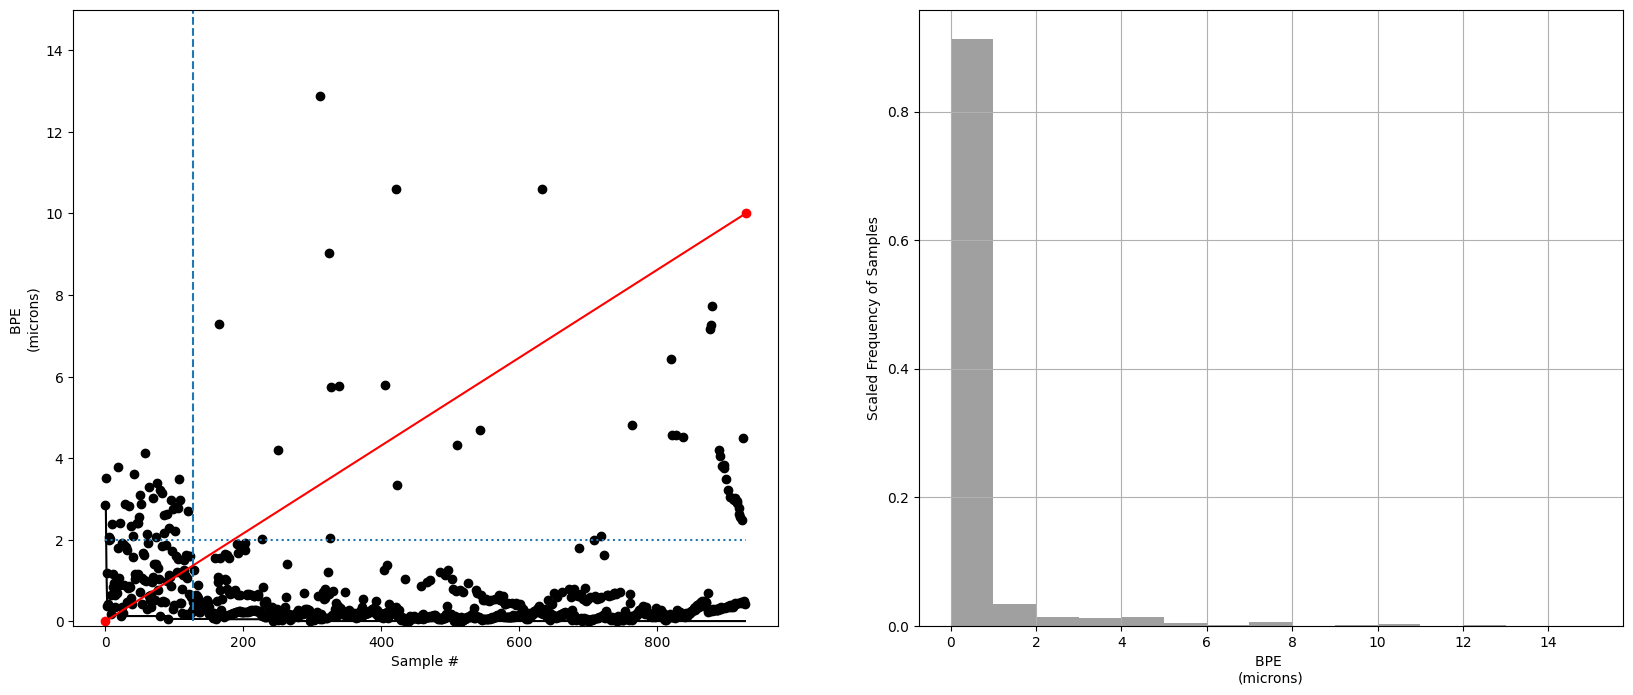

In [109]:
y1 = X.data["f"]
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(1,2,1)
y1_maxs = np.minimum.accumulate(y1)
ax1.plot(y1, 'ok')
ax1.plot(y1_maxs, 'k')
#plt.hlines(1, 0, len(y1_maxs), linestyles="dotted")
ax1.vlines(n_init, 0, 20, linestyles="dashed")
ax1.hlines(2, 0, len(y1), linestyles="dotted")
ax1.set_ylabel("BPE \n(microns)")
ax1.set_xlabel("Sample #")
ax1.set_ylim(-0.1, 15)


a=[0, len(y1)]
b=[0, 10]
for i in range(0, len(a), 2):
    ax1.plot(a[i:i+2], b[i:i+2], 'ro-')

ax2 = fig.add_subplot(1,2,2)
ax2.hist(y1[n_init:], density=True, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], facecolor='gray', alpha=0.75)
ax2.set_ylabel("Scaled Frequency of Samples")
ax2.set_xlabel("BPE \n(microns)")
ax2.grid()
#plt.savefig(f'AnisotropicDriftCorrection_TDBO.png', dpi=200)
plt.show()

In [36]:
X.data.to_csv('history.csv', index=False)